In [4]:
import pandas as pd
import numpy as np
import os 
import glob
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn import metrics


import seaborn as sns

#a updated version of savvastj/nbashots used for kde shot plots had to update from 9 year old seaborn syntax
#import shot_printer as sp

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

#for shot ploting
#import importlib
#importlib.reload(sp)


# Import and Clean data
data fetched from NBA API using methods in get_data.ipynb

In [255]:
#Dont Run me
#Convert year by year files to One big CSV
files = glob.glob(os.path.join('Data/byYear/',"*.csv"))
dataframes = {}

for file in files:
    file_name = os.path.basename(file)
    base_name = os.path.splitext(file_name)[0]
    df = pd.read_csv(file)
    dataframes[base_name] = df

box_data = pd.DataFrame()
advanced_box_data = pd.DataFrame()
play_by_play = pd.DataFrame()
play_type = pd.DataFrame()
playertracking_data = pd.DataFrame()
shotchart_data = pd.DataFrame()

for name, df in dataframes.items():
    if 'advanced_box_data' in name:
        advanced_box_data = pd.concat([advanced_box_data, df], ignore_index=True)
    elif 'box_data' in name:
        box_data = pd.concat([box_data, df], ignore_index=True)
    elif 'play_by_play' in name:
        play_by_play = pd.concat([play_by_play, df], ignore_index=True)
    elif 'play_type' in name:
        play_type = pd.concat([play_type, df], ignore_index=True)
    elif 'playertracking_data' in name:
        playertracking_data = pd.concat([playertracking_data, df], ignore_index=True)
    elif 'shotchart_data' in name:
        shotchart_data = pd.concat([shotchart_data, df], ignore_index=True)

advanced_box_data.to_csv(data_path +'player_advanced_box_data_13_to_24.csv')
box_data.to_csv(data_path + 'player_box_data_13_to_24.csv')
playertracking_data.to_csv(data_path + 'playertracking_data_13_to_24.csv')
shotchart_data.to_csv(data_path + 'player_shotchart_data_13_to_24.csv')

#player_advanced_box_data.to_csv(data_path + 'player_advanced_box_data_13_to_24.csv')

In [1]:
data_path = 'Data/'

In [80]:
#input dataframes

player_box_data= pd.read_csv(data_path + 'player_box_data_13_to_24.csv')
player_tracking_data= pd.read_csv(data_path + 'playertracking_data_13_to_24.csv')
player_shotchart_data = pd.read_csv(data_path + 'player_shotchart_data_13_to_24.csv')
player_advanced_box_data = pd.read_csv(data_path + 'player_advanced_box_data_13_to_24.csv')

team_game_adv_stats = pd.read_csv(data_path + 'team_advanced_stats_per_game_2013_to_2024.csv')
team_game_stats = pd.read_csv(data_path + 'nba_team_game_logs_2013_to_2024.csv')
player_game_stats = pd.read_csv(data_path + 'nba_player_game_logs_2013_to_2024.csv')

#have data not using
#player_play_by_play = pd.read_csv(data_path + 'player_play_by_play_data_23_to_24.csv')
player_play_type = pd.read_csv(data_path + 'player_play_type_data_13_to_24.csv')

In [59]:
player_shotchart_data['SHOT_ZONE_RANGE'].unique()

array(['Less Than 8 ft.', '16-24 ft.', '24+ ft.', '8-16 ft.',
       'Back Court Shot'], dtype=object)

In [4]:
player_shotchart_data

Unnamed: 0          GRID_TYPE   GAME_ID  GAME_EVENT_ID  PLAYER_ID       PLAYER_NAME     TEAM_ID            TEAM_NAME  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING   EVENT_TYPE                     ACTION_TYPE       SHOT_TYPE        SHOT_ZONE_BASIC         SHOT_ZONE_AREA  SHOT_ZONE_RANGE  SHOT_DISTANCE  LOC_X  LOC_Y  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG  GAME_DATE  HTM  VTM
0                 0  Shot Chart Detail  21300002              3       2617     Udonis Haslem  1610612748           Miami Heat       1                 11                 43    Made Shot                       Dunk Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              0      2      3                    1               1   20131029  MIA  CHI
1                 1  Shot Chart Detail  21300002              4     202710      Jimmy Butler  1610612741        Chicago Bulls       1                 11                 17  Missed Shot                       Jump Shot  2PT Field Goal              Mid-Range   Left Side Center(LC)        16-24 ft.             21   -134    164                    1               0   20131029  MIA  CHI
2                 2  Shot Chart Detail  21300002              6       2548       Dwyane Wade  1610612748           Miami Heat       1                 11                 10  Missed Shot                       Jump Shot  2PT Field Goal              Mid-Range          Right Side(R)        16-24 ft.             20    181    101                    1               0   20131029  MIA  CHI
3                 3  Shot Chart Detail  21300002              9       2547        Chris Bosh  1610612748           Miami Heat       1                 10                 37  Missed Shot                       Jump Shot  3PT Field Goal      Above the Break 3  Right Side Center(RC)          24+ ft.             25    226    127                    1               0   20131029  MIA  CHI
4                 4  Shot Chart Detail  21300002             11     201565      Derrick Rose  1610612741        Chicago Bulls       1                 10                 22    Made Shot              Driving Layup Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              1      6      9                    1               1   20131029  MIA  CHI
...             ...                ...       ...            ...        ...               ...         ...                  ...     ...                ...                ...          ...                             ...             ...                    ...                    ...              ...            ...    ...    ...                  ...             ...        ...  ...  ...
2289862     2289862  Shot Chart Detail  22301187            581    1630550           JT Thor  1610612766    Charlotte Hornets       4                  1                 29  Missed Shot             Step Back Jump shot  3PT Field Goal      Above the Break 3              Center(C)          24+ ft.             25    -15    251                    1               0   20240414  CLE  CHA
2289863     2289863  Shot Chart Detail  22301187            583    1641734       Emoni Bates  1610612739  Cleveland Cavaliers       4                  1                 20  Missed Shot  Running Finger Roll Layup Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              1      1     15                    1               0   20240414  CLE  CHA
2289864     2289864  Shot Chart Detail  22301187            586     202684  Tristan Thompson  1610612739  Cleveland Cavaliers       4                  1                  6  Missed Shot               Driving Dunk Shot  2PT Field Goal        Restricted Area              Center(C)  Less Than 8 ft.              0      9      2                    1               0   20240414  CLE  CHA
2289865     2289865  Shot Chart Detail  22301187            589    1641733    Nick Smith Jr.  1610612766    Charlotte Hornets       4                  0                 46    Made

In [96]:
#columns with no data for all players
player_box_data.dropna(inplace=True,axis =1 )

# Create key columns
player_advanced_box_data['combined_key'] = player_advanced_box_data['gameId'].astype(str) + '_' + player_advanced_box_data['personId'].astype(str)
player_tracking_data['combined_key'] = player_tracking_data['gameId'].astype(str) + '_' + player_tracking_data['personId'].astype(str)
player_box_data['combined_key'] = player_box_data['gameId'].astype(str) + '_' + player_box_data['personId'].astype(str)

#merge on key drop duplcated columns
#https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
big_box = player_advanced_box_data.merge(player_tracking_data, on='combined_key', how='outer', suffixes=('', '_y'))
big_box.drop(big_box.filter(regex='_y$').columns, axis=1, inplace=True)

big_box = big_box.merge(player_tracking_data, on='combined_key', how='outer', suffixes=('', '_y'))
big_box.drop(big_box.filter(regex='_y$').columns, axis=1, inplace=True)

big_box.drop(columns=['combined_key'],inplace=True)

#na values
    #position: non starters have no position data, Drop will make our own
    #comment: only rows with values are for did not play coaches dcision or Injury, and na
    #jerseyNum: not a single value, Drop no value
    #minutes: inverse of comment collumn, fill zeros

big_box = big_box.drop(columns=['jerseyNum','Unnamed: 0','GAME_ID'])
big_box.fillna({'minutes' : '00:00', 'position' : 'n','comment' : 'none'},inplace=True)

#dont know why 3 rows of nan
big_box.dropna(inplace=True,axis=0)


df_team_stats = team_game_stats.merge(team_game_adv_stats, on=['GAME_ID', 'TEAM_ID'], how='inner')
# W to 1 and L to 0
df_team_stats['WL'] = df_team_stats['WL'].apply(lambda x: 1 if x == 'W' else 0)

# removes "Rank" columns
df_team_stats = df_team_stats.drop(columns=[col for col in df_team_stats.columns if col.endswith('RANK')])

#rebounds
null_or_zero_oreb_pct = df_team_stats[(df_team_stats['OREB_PCT'].isnull()) | (df_team_stats['OREB_PCT'] == 0)]

#find rows with absolutely no reb data
no_rebounding_data = df_team_stats[
    (df_team_stats['OREB_PCT'].isnull() | (df_team_stats['OREB_PCT'] == 0)) &
    (df_team_stats['DREB_PCT'].isnull() | (df_team_stats['DREB_PCT'] == 0)) &
    (df_team_stats['REB_PCT'].isnull() | (df_team_stats['REB_PCT'] == 0))
]

#Home Away
df_team_stats['HOME_AWAY'] = df_team_stats['MATCHUP'].apply(lambda x: 1 if 'vs' in x else 0)

# Create opponent statistics using the GAME_ID
df_team_stats['OppOREB'] = df_team_stats.groupby('GAME_ID')['OREB'].shift(-1)
df_team_stats['OppDREB'] = df_team_stats.groupby('GAME_ID')['DREB'].shift(-1)
df_team_stats['OppREB'] = df_team_stats.groupby('GAME_ID')['REB'].shift(-1)

# Apply the same logic in reverse for the other team in the same game
df_team_stats['OppOREB'].fillna(df_team_stats.groupby('GAME_ID')['OREB'].shift(1), inplace=True)
df_team_stats['OppDREB'].fillna(df_team_stats.groupby('GAME_ID')['DREB'].shift(1), inplace=True)
df_team_stats['OppREB'].fillna(df_team_stats.groupby('GAME_ID')['REB'].shift(1), inplace=True)

# fill missing OREB_PCT, DREB_PCT, and REB_PCT values using the rebounding formulas
df_team_stats['OREB_PCT'] = np.where(df_team_stats['OREB_PCT'].isnull(),
                                      df_team_stats['OREB'] / (df_team_stats['OREB'] + df_team_stats['OppDREB']),
                                      df_team_stats['OREB_PCT'])

df_team_stats['DREB_PCT'] = np.where(df_team_stats['DREB_PCT'].isnull(),
                                      df_team_stats['DREB'] / (df_team_stats['DREB'] + df_team_stats['OppOREB']),
                                      df_team_stats['DREB_PCT'])

df_team_stats['REB_PCT'] = np.where(df_team_stats['REB_PCT'].isnull(),
                                     df_team_stats['REB'] / (df_team_stats['REB'] + df_team_stats['OppREB']),
                                     df_team_stats['REB_PCT'])

#dropping available flag, usage %, and newly-created opp reb. Team usage % for a game is going to be 100%, so it's not useful data
df_team_stats = df_team_stats.drop(columns=['USG_PCT', 'AVAILABLE_FLAG','OppOREB','OppDREB','OppREB'])

#Adding team win perc. for season up to each game
df_team_stats = df_team_stats.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_ID'])

df_team_stats['cumulative_wins'] = df_team_stats.groupby(['TEAM_ID', 'SEASON_YEAR'])['WL'].cumsum().shift(1)  # Shift to exclude current game
df_team_stats['games_played'] = df_team_stats.groupby(['TEAM_ID', 'SEASON_YEAR']).cumcount()

df_team_stats['games_played'] = df_team_stats['games_played'].replace(0, 1)

df_team_stats['win_percentage'] = df_team_stats['cumulative_wins'] / df_team_stats['games_played']

#grab numerics
df_team_numeric = df_team_stats.select_dtypes(include=['float64', 'int64'])

df_team_numeric.head()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


TEAM_ID   GAME_ID  WL  MIN_x  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  BLK  BLKA  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  DREB_PCT   REB_PCT  E_TM_TOV_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  E_USG_PCT  E_PACE   PACE  PACE_PER40  POSS    PIE  HOME_AWAY  cumulative_wins  games_played  win_percentage
2429  1610612737  21300012   0   48.0   37   76   0.487     8    24    0.333   27   35   0.771     5    28   33   27  17.0   16    5     2  20   22  109        -9.0         105.4       104.8         117.3       114.6         -11.9        -9.8    0.730     1.59       19.9  0.182000     0.800  0.440000        16.441        16.3    0.539   0.596      0.201  101.98  103.5       86.25   104  0.467          0              NaN             1             NaN
2408  1610612737  21300023   1   48.0   36   77   0.468    10    23    0.435   20   31   0.645     7    30   37   24  13.0    7    3     6  12   25  102         7.0         105.5       107.4          98.8       100.0           6.8         7.4    0.667     1.85       18.8  0.234000     0.720  0.485000        13.452        13.7    0.532   0.563      0.201   96.40   95.0       79.17    95  0.587          1              0.0             1        0.000000
2379  1610612737  21300046   0   48.0   40   90   0.444     9    22    0.409   14   26   0.538    10    42   52   26  13.0    9    3     7  22   24  103        -2.0          98.6        97.2          98.5       100.0           0.1        -2.8    0.650     2.00       18.5  0.175439     0.830  0.495238        12.447        12.3    0.494   0.508      0.197  105.50  105.5       87.92   106  0.476          0              1.0             2        0.500000
2358  1610612737  21300059   1   48.0   39   81   0.481     8    22    0.364   19   26   0.731     9    27   36   26  14.0   11    7     4  15   26  105         5.0         107.8       109.4         102.8       103.1           4.9         6.3    0.667     1.86       19.6  0.239000     0.717  0.478000        14.368        14.6    0.531   0.568      0.201   97.34   96.5       80.42    96  0.559          0              1.0             3        0.333333
2320  1610612737  21300071   0   48.0   43   94   0.457     8    26    0.308   13   19   0.684    13    33   46   31  11.0   11    9     8  23   18  107        -2.0         106.6       109.2         109.6       112.4          -3.0        -3.2    0.721     2.82       21.5  0.321000     0.745  0.520000        10.961        11.2    0.500   0.523      0.198   99.92   97.5       81.25    98  0.502          0              2.0             4        0.500000

In [7]:

print("Num Games ")
print( "team game stats:", len(set(team_game_stats['GAME_ID'])))
print( "team game advanced stats:", len(set(team_game_adv_stats['GAME_ID'])))
print( "player game  stats:", len(set(player_game_stats['GAME_ID'])))
print("----------------------------")
print("kaden combined Player stats:",len(set(big_box['gameId'])))

Num Games 
team game stats: 13209
team game advanced stats: 13190
player game  stats: 13209
----------------------------
kaden combined Player stats: 13209


# Player rolling stats

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import BaseEstimator

def k_means(X,n_cluster,n_rand):
    best_labels = None
    best_silhoutte = -100
    
    for trial in range(n_rand):
        random_state = np.random.randint(1,1000)
        clusterer = KMeans(n_clusters=n_cluster, random_state=random_state, n_init=500, init='k-means++')
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X,cluster_labels)

        if silhouette_avg > best_silhoutte:
            best_labels = cluster_labels
    return best_labels

def silhouette_auc(X, clusters_range): #calculate the area under the sihouette curve 
    scores = []
    for n_clusters in clusters_range:
        labels = k_means(X,n_clusters,n_rand=1)
        silhouette_avg = silhouette_score(X,labels)
        scores.append(silhouette_avg)
    return np.trapz(scores,clusters_range) # np.trapz, good ol trapizodial method for definate integrals, 

# Wrapper class for silhouette_auc, used to make work with sklearn estimator interface - gotten from GPT so i didnt have to figure out how to write one
class SilhouetteAUCWrapper(BaseEstimator):
    def __init__(self, clusters_range):
        self.clusters_range = clusters_range

    def fit(self, X, y=None):
        return self  # Not used for scoring

    def score(self, X, y=None):
        return silhouette_auc(X, self.clusters_range)


from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}


for s in season_prefixs:
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games
#iterate though season
season_cluster_dict = {}
season_shot_dict = {}
#season_team_data_dict = {}
all_team_data = []

fig, ax = plt.subplots(figsize=(10, 6))


for s in season_game_dict:
    games = season_game_dict[s]
    #get seasons data
    season_big_box = big_box[big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = player_shotchart_data[player_shotchart_data['GAME_ID'].isin(games)]
    season_player_play_type = player_play_type[player_play_type['SEASON_ID'].astype(str).str[-2:] == str(s)[-2:]]

    #get play type 
    season_player_play_type = season_player_play_type.pivot_table(index= 'PLAYER_ID', columns= ['TYPE_GROUPING','PLAY_TYPE'], values='PERCENTILE').fillna(0)
    season_player_play_type.columns = ['_'.join(col).strip() for col in season_player_play_type.columns.values]
    season_player_play_type.reset_index()

    season_shot_dict[s] = season_shot_chart
    cluster_big_box = season_big_box.copy()
    X = cluster4000(cluster_big_box,season_shot_chart, season_player_play_type) # get player dataframes for clustering 
    
    # remove low variance columns 
    pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    var = scaled_asdf.var(axis=0)
    low_var_columns = var[var <0.2].index.tolist()
    columns_to_drop = low_var_columns + ['gameId']  
    X.drop(columns=columns_to_drop, axis=1, inplace=True)
    
    X_scaled = RobustScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns.difference(low_var_columns))


    n_clusters_range = range(5,10)
    sfs = SequentialFeatureSelector(estimator=SilhouetteAUCWrapper(clusters_range=  n_clusters_range))
    sfs.fit(X_scaled)
    selected_indices = sfs.get_support(indices=True)
    selected_feature_names = X_scaled.columns[selected_indices].tolist()
    print(f' selected_features for season {s}: {selected_feature_names}')

In [76]:
results = ['minutes', 'offensiveRating', 'defensiveRating', 'netRating', 'assistPercentage', 'assistToTurnover', 'assistRatio', 'offensiveReboundPercentage', 'defensiveReboundPercentage', 'reboundPercentage', 'turnoverRatio', 'effectiveFieldGoalPercentage', 'trueShootingPercentage', 'usagePercentage', 'pace', 'pacePer40', 'PIE', 'speed', 'distance', 'reboundChancesOffensive', 'reboundChancesDefensive', 'reboundChancesTotal', 'touches', 'secondaryAssists', 'freeThrowAssists']

In [ ]:
set(X_scaled.columns.tolist()) #- set(X_scaled.columns[:24].tolist())

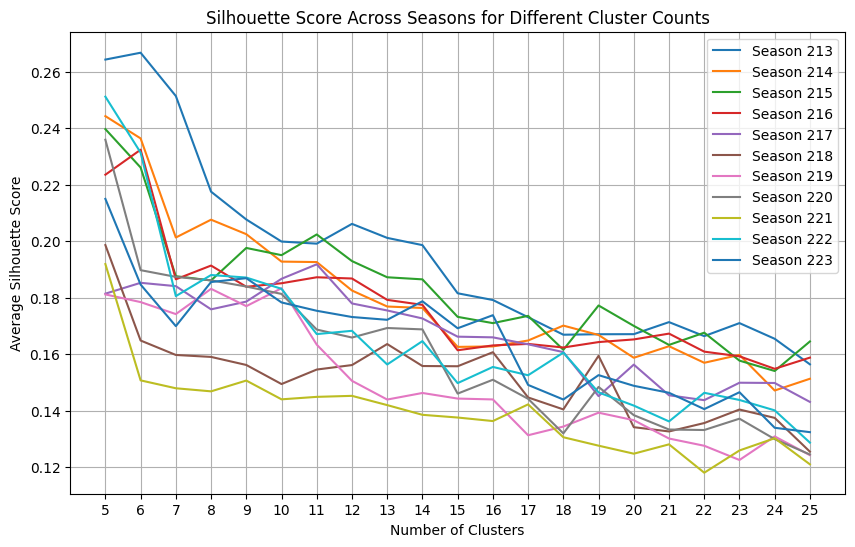

In [95]:
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}


for s in season_prefixs:
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games
#iterate though season
season_cluster_dict = {}
season_shot_dict = {}
#season_team_data_dict = {}
all_team_data = []

fig, ax = plt.subplots(figsize=(10, 6),dpi = 300)


for s in season_game_dict:
    games = season_game_dict[s]
    #get seasons data
    season_big_box = big_box[big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = player_shotchart_data[player_shotchart_data['GAME_ID'].isin(games)]
    season_player_play_type = player_play_type[player_play_type['SEASON_ID'].astype(str).str[-2:] == str(s)[-2:]]

    #get play type 
    season_player_play_type = season_player_play_type.pivot_table(index= 'PLAYER_ID', columns= ['TYPE_GROUPING','PLAY_TYPE'], values='PERCENTILE').fillna(0)
    season_player_play_type.columns = ['_'.join(col).strip() for col in season_player_play_type.columns.values]
    season_player_play_type.reset_index()

    season_shot_dict[s] = season_shot_chart
    cluster_big_box = season_big_box.copy()
    X = cluster4000(cluster_big_box,season_shot_chart, season_player_play_type) # get player dataframes for clustering 
    
    # remove low variance columns 
    pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    var = scaled_asdf.var(axis=0)
    low_var_columns = var[var <0.2].index.tolist()
    X.drop(low_var_columns,axis = 1)
    asdf = X.copy()
    
    X = X[all_selected_features]
    X = RobustScaler().fit_transform(X)

    silhouette_list = []
    for n_clusters in range(5,26):
        labels = k_means(X,n_clusters,n_rand=3)

        silhouette_avg = silhouette_score(X,labels)
        silhouette_list.append(silhouette_avg)
        sample_silhouette_values = silhouette_samples(X,labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        if 1==2:     
            print(
                "For n_clusters =",
                n_clusters,
                "The average silhouette_score is :",
                round(silhouette_avg,5),
                "caliniski harabasz score",
                round(metrics.calinski_harabasz_score(X, labels),2)
            )
    ax.plot(range(5,26),silhouette_list,label=f'Season {s}')
    
ax.set_title('Silhouette Score Across Seasons for Different Cluster Counts')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Score')
ax.legend(loc='best')
ax.grid(True)
ax.set_xticks(range(5,26))
plt.show()      

In [119]:
def k_means(X,n_cluster,n_rand):
    best_silhoutte = -100
    best_labels = None

    for trial in range(n_rand):
        random_state = np.random.randint(1,1000)
        clusterer = KMeans(n_clusters=n_cluster, random_state=random_state, n_init=500, init='k-means++')
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X,cluster_labels)

        if silhouette_avg > best_silhoutte:
            best_labels = cluster_labels
    return best_labels, clusterer


In [159]:
# function to produce per season clustering
def cluster4000(df,shot_df, play_type):
    #remove the fluf
    df.drop([ 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug','firstName','possessions', #'gameId',
                                'familyName', 'nameI'],axis=1,inplace =True)
    df.drop(df.filter(like='estimated').columns, axis=1,inplace = True)

    #get players
    player_set = set(df['personId'])

    #convert time to seconds
    #https://stackoverflow.com/questions/63663747/pandas-convert-time-into-seconds-for-all-values-in-column
    df['minutes']=df['minutes'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))

    #get season averages
    df_player = df.groupby('personId').mean(numeric_only=True).reset_index()

    #add average play time and % starting 5
    for player in player_set:
        try:
            avg_play_time = df[df['personId'] == player]['minutes'].sum() / len(df[df['personId'] == player]) /60
        except:
            avg_play_time = 0
        df.loc[df['personId'] == player, 'min_per_game'] = avg_play_time
        try:
            starter_pct = sum(df[df['personId'] == player]['position'] != 'n') / len(df[df['personId'] == player])
        except:
            starter_pct = 0
        df.loc[df['personId'] == player, 'pct_games_started'] = starter_pct

    ######adding player shot location data

    shot_chart_num = shot_df.drop([
        'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME',
        'PERIOD', 'ACTION_TYPE', 'SHOT_TYPE', 'MINUTES_REMAINING', 'EVENT_TYPE',
        'SECONDS_REMAINING', 'GAME_DATE', 'HTM', 'VTM', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE'
    ], axis=1)

    player_shot_summaries = pd.DataFrame()

    # calculate shooting stats for different zones
    for player_id, player_df in shot_chart_num.groupby('PLAYER_ID'):

        zone_summary = player_df.groupby(['SHOT_ZONE_BASIC']).agg(
            shot_attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),  # Change from size to sum
            made_shots=('SHOT_MADE_FLAG', 'sum')
        ).reset_index()
        
        # Add player ID and clean up columns
        zone_summary['PLAYER_ID'] = player_id
        zone_summary['Location'] = zone_summary['SHOT_ZONE_BASIC']
        zone_summary = zone_summary.drop(['SHOT_ZONE_BASIC'], axis=1)
        
        # Pivot and flatten columns
        pivot_table = zone_summary.pivot_table(
            index='PLAYER_ID',
            columns='Location',
            values=['shot_attempts', 'made_shots'],  # Use shot_attempts and made_shots
            aggfunc='sum'
        )
        pivot_table.columns = [f'{stat}_{location}'.replace(' ', '_') for stat, location in pivot_table.columns]
        pivot_table.reset_index(inplace=True)
        
        player_shot_summaries = pd.concat([player_shot_summaries, pivot_table], ignore_index=True)

    # Merge with the box23_24_player DataFrame
    df_player_shots = df_player.merge(player_shot_summaries, left_on='personId', right_on='PLAYER_ID', how='outer',suffixes=('', '_y'))

    # Fill NaN values with 0 for people with no shots or missing shot positions
    df_player_shots = df_player_shots.fillna(0)

    #add play type data 
    df_player_shots.merge(play_type, left_on='personId', right_on='PLAYER_ID', how = 'outer')

    
    #data's ready drop the ID's and scale
    to_cluster = df_player_shots.drop(['PLAYER_ID'],axis = 1)

    scaled_box = RobustScaler().fit_transform(to_cluster)
    #input

    X = to_cluster
    return X
    #clusterer = KMeans(n_clusters=14, random_state=42, n_init=100, init='k-means++')
    #cluster_labels = clusterer.fit_predict(X)
    #results = pd.DataFrame(df_player['personId'])
   # results['cluster'] = k_means(X)

   # results_id = results[['personId','cluster']]
  #  cluster_shots = results_id.merge(df_player_shots, on='personId', how='outer')
  #  cluster_shots.drop(['PLAYER_ID'], inplace = True,axis = 1)

  #  return cluster_shots

In [99]:
#make a dictonary of games in each season 
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}

for s in season_prefixs: 
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games

all_clusters = [f'cluster_{i}' for i in range(n_cluster)]

In [158]:
# function to produce per season clustering
def cluster4000_processed(df,shot_df, play_type,n_clusters):
    #remove the fluf
    df.drop([ 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug','firstName','possessions', #'gameId',
                                'familyName', 'nameI'],axis=1,inplace =True)
    df.drop(df.filter(like='estimated').columns, axis=1,inplace = True)

    #get players
    player_set = set(df['personId'])

    #convert time to seconds
    #https://stackoverflow.com/questions/63663747/pandas-convert-time-into-seconds-for-all-values-in-column
    df['minutes']=df['minutes'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))

    #get season averages
    df_player = df.groupby('personId').mean(numeric_only=True).reset_index()

    #add average play time and % starting 5
    for player in player_set:
        try:
            avg_play_time = df[df['personId'] == player]['minutes'].sum() / len(df[df['personId'] == player]) /60
        except:
            avg_play_time = 0
        df.loc[df['personId'] == player, 'min_per_game'] = avg_play_time
        try:
            starter_pct = sum(df[df['personId'] == player]['position'] != 'n') / len(df[df['personId'] == player])
        except:
            starter_pct = 0
        df.loc[df['personId'] == player, 'pct_games_started'] = starter_pct

    ######adding player shot location data

    shot_chart_num = shot_df.drop([
        'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME',
        'PERIOD', 'ACTION_TYPE', 'SHOT_TYPE', 'MINUTES_REMAINING', 'EVENT_TYPE',
        'SECONDS_REMAINING', 'GAME_DATE', 'HTM', 'VTM', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE'
    ], axis=1)

    player_shot_summaries = pd.DataFrame()

    # calculate shooting stats for different zones
    for player_id, player_df in shot_chart_num.groupby('PLAYER_ID'):

        zone_summary = player_df.groupby(['SHOT_ZONE_BASIC']).agg(
            shot_attempts=('SHOT_ATTEMPTED_FLAG', 'sum'),  # Change from size to sum
            made_shots=('SHOT_MADE_FLAG', 'sum')
        ).reset_index()
        
        # Add player ID and clean up columns
        zone_summary['PLAYER_ID'] = player_id
        zone_summary['Location'] = zone_summary['SHOT_ZONE_BASIC']
        zone_summary = zone_summary.drop(['SHOT_ZONE_BASIC'], axis=1)
        
        # Pivot and flatten columns
        pivot_table = zone_summary.pivot_table(
            index='PLAYER_ID',
            columns='Location',
            values=['shot_attempts', 'made_shots'],  # Use shot_attempts and made_shots
            aggfunc='sum'  
        )
        pivot_table.columns = [f'{stat}_{location}'.replace(' ', '_') for stat, location in pivot_table.columns]
        pivot_table.reset_index(inplace=True)
        
        player_shot_summaries = pd.concat([player_shot_summaries, pivot_table], ignore_index=True)

    # Merge with the box23_24_player DataFrame
    df_player_shots = df_player.merge(player_shot_summaries, left_on='personId', right_on='PLAYER_ID', how='outer',suffixes=('', '_y'))

    # Fill NaN values with 0 for people with no shots or missing shot positions
    df_player_shots = df_player_shots.fillna(0)

    #add play type data 
    df_player_shots.merge(play_type, left_on='personId', right_on='PLAYER_ID', how = 'outer')

    df_player_shots.reset_index()
    #data's ready drop the ID's and scale
    to_cluster = df_player_shots.drop(['PLAYER_ID','personId'],axis = 1)

    scaled_box = RobustScaler().fit_transform(to_cluster)
    #input

    X = to_cluster
    
    #clusterer = KMeans(n_clusters=14, random_state=42, n_init=100, init='k-means++')
    cluster_labels, model = k_means(X,n_cluster,10) #pass to cluster dataframe, create 10 clusters, with 10 different random seads, return the best. 
    results = pd.DataFrame(df_player['personId'])
    results['cluster'] = cluster_labels

    results_id = results[['personId','cluster']]
    cluster_shots = results_id.merge(df_player_shots, on='personId', how='outer')
    cluster_shots.drop(['PLAYER_ID'], inplace = True,axis = 1)

    return X, model

### how to calculate cluster values



In [ ]:
#make a dictonary of games in each season
season_prefixs = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {}

n_cluster = 10

columns_to_roll = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
                   'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING',
                   'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
                   'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_USG_PCT', 'E_PACE', 'PACE',
                   'PACE_PER40', 'POSS', 'PIE']
        #produce output dataframe and calculate rolling team statistics
        #output = team_data.copy()
        #for col in columns_to_roll:
        #    output[col + '_rolling'] = output[col].rolling(window=5, min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else np.nan)


for s in season_prefixs:
    season_games = [game for game in games if game.startswith(s)]
    season_games = [float(g) for g in season_games]
    season_game_dict[s] = season_games
#iterate though season
season_cluster_dict = {}

#season_team_data_dict = {}
all_team_data = []
for s in season_game_dict:
    games = season_game_dict[s]
    #get seasons data
    season_big_box = big_box[big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = player_shotchart_data[player_shotchart_data['GAME_ID'].isin(games)]
    season_player_play_type = player_play_type[player_play_type['SEASON_ID'].astype(str).str[-2:] == str(s)[-2:]]

    #get play type 
    season_player_play_type = season_player_play_type.pivot_table(index= 'PLAYER_ID', columns= ['TYPE_GROUPING','PLAY_TYPE'], values='PERCENTILE').fillna(0)
    season_player_play_type.columns = ['_'.join(col).strip() for col in season_player_play_type.columns.values]
    season_player_play_type.reset_index()

    # get cluster information 
    cluster_big_box = season_big_box.copy()
    cluster_df, model = cluster4000_processed(cluster_big_box,season_shot_chart, season_player_play_type,n_cluster) # get cluster information 
    
    season_cluster_dict[s] = [cluster_df,model]
    #team_data_dict = {}
    #work through each team
    for teamId in big_box['teamId'].unique():
        #get data for individual and team, sort team data chronological
        team_data = season_team_game_stats[season_team_game_stats['TEAM_ID'] == teamId]
        team_data.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_DATE'],inplace=True )
        team_data.reset_index(drop=True, inplace=True)
        player_data = season_big_box[season_big_box['teamId']==teamId]

        team_data['rolling_games'] = [
            team_data['GAME_ID'][max(0, i-5):i].tolist() for i in range(len(team_data))
        ]

        for cluster in all_clusters:
            if cluster not in team_data.columns:
                team_data[cluster] = 0
             
        for idx in team_data.index:
            prev_games = team_data['rolling_games'][idx]
            if not prev_games:  # Skip if the list is empty
                continue
            all_players_stats = []
            for game in prev_games:
                players = player_data[player_data['gameId']== game]
                players_shot_chart = season_shot_chart[season_shot_chart['GAME_ID'].isin(prev_games)]
                all_players_stats.append(players[['personId','usagePercentage']])
            if all_players_stats:
                window_players_stats = pd.concat(all_players_stats, ignore_index=True)
                try:
                    season_player_play_type = season_player_play_type.reset_index()
                except:
                    pass
                to_cluster = cluster4000(players,players_shot_chart,season_player_play_type[season_player_play_type['PLAYER_ID'].isin(all_players_stats)])
                to_cluster = to_cluster[to_cluster['gameId'] > 1].reset_index()
                player_id = to_cluster['personId']
                to_cluster.drop('personId',axis=1,inplace=True)
                labels = model.fit_predict(to_cluster)
                filtered_players = players[players['minutes'] > 0]
                cluster_labels = pd.DataFrame(player_id)
                cluster_labels['cluster'] = labels
                
                window_players_stats = window_players_stats.merge(cluster_labels[['personId','cluster']], on='personId')
                #window_players_stats = window_players_stats.iloc[:,:2]
                
                grouped_stats = window_players_stats.groupby('cluster', as_index=False)['usagePercentage'].sum()
                pivoted_stats = grouped_stats.reset_index().pivot_table(index=grouped_stats.index, columns='cluster', values='usagePercentage', aggfunc='sum')

                pivoted_stats.columns = [f'cluster_{col}' for col in pivoted_stats.columns]
                all_clusters = [f'cluster_{i}' for i in range(n_cluster)]
                for cluster in all_clusters:
                    if cluster not in pivoted_stats.columns:
                        pivoted_stats[cluster] = 0
                #sort and sum 
                pivoted_stats = pivoted_stats[sorted(pivoted_stats.columns, key=lambda x: int(x.split('_')[1]))]
                summed_stats = pivoted_stats.sum().to_frame().T

                #account for variation in number of games in window
                summed_stats = summed_stats / len(pivoted_stats)
                #add to team_data
                team_data.loc[idx, summed_stats.columns] = summed_stats.iloc[0]
                
        all_team_data.append(team_data)
        #team_data_dict[teamId] = team_data


    #season_team_data_dict[s] = team_data_dict
final_team_data = pd.concat(all_team_data, ignore_index=True)


# Team Rolling Setup

In [169]:
final_team_data.head() 

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME   GAME_ID            GAME_DATE      MATCHUP WL   MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  BLK  BLKA  PF  PFD  PTS  PLUS_MINUS  GP_RANK  W_RANK  L_RANK  W_PCT_RANK  MIN_RANK  FGM_RANK  FGA_RANK  FG_PCT_RANK  FG3M_RANK  FG3A_RANK  FG3_PCT_RANK  FTM_RANK  FTA_RANK  FT_PCT_RANK  OREB_RANK  DREB_RANK  REB_RANK  AST_RANK  TOV_RANK  STL_RANK  BLK_RANK  BLKA_RANK  PF_RANK  PFD_RANK  PTS_RANK  PLUS_MINUS_RANK  AVAILABLE_FLAG   Season                             rolling_games  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  cluster_8  cluster_9
0     2013-14  1610612753               ORL  Orlando Magic  21300001  2013-10-29T00:00:00    ORL @ IND  L  48.0   36   93   0.387     9    19    0.474    6   10   0.600    13    26   39   17  19.0   10    6    18  26   13   87       -10.0        1    1231    1231        1231       159      1460       212         2183        668       1533           311      2416      2389         2269        585       2067      1686      1979      2065       406       537       2459     2132      2358      2144             1883             1.0  2013-14                                        []     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000
1     2013-14  1610612753               ORL  Orlando Magic  21300010  2013-10-30T00:00:00    ORL @ MIN  L  53.0   47  100   0.470    10    27    0.370   11   18   0.611    14    40   54   21  18.0    7    6     3  29   19  115        -5.0        1    1231    1231        1231        29        69        36          958        472        397          1098      2090      1820         2242        451        143       114      1313      1899      1221       537        483     2349      1458       278             1489             1.0  2013-14                                [21300001]     0.0254     0.0000     0.0258     0.0395     0.0105     0.0224     0.0239     0.0091     0.0198     0.0281
2     2013-14  1610612753               ORL  Orlando Magic  21300021  2013-11-01T00:00:00  ORL vs. NOP  W  48.0   39   70   0.557    11    22    0.500   21   27   0.778     5    39   44   22  19.0   11    7     5  19   21  110        20.0        1       1       1           1       159       862      2362           86        317       1024           167       642       705         1063       2301        186       915      1113      2065       256       333       1269      777      1001       526              160             1.0  2013-14                      [21300001, 21300010]     0.0190     0.0895     0.0105     0.0350     0.0383     0.0393     0.0494     0.0306     0.0174     0.0494
3     2013-14  1610612753               ORL  Orlando Magic  21300043  2013-11-03T00:00:00  ORL vs. BKN  W  48.0   42   89   0.472     7    17    0.412   16   22   0.727    13    41   54   19  15.0    7    4     8  19   23  107        21.0        1       1       1           1       159       405       450          932       1231       1822           719      1385      1292         1537        585         93       114      1681      1204      1221      1193       2129      777       624       708              138             1.0  2013-14            [21300001, 21300010, 21300021]     0.0271     0.0697     0.0174     0.0613     0.0730     0.0105     0.0634     0.0993     0.0718     0.0524
4     2013-14  1610612753               ORL  Orlando Magic  21300062  2013-11-06T00:00:00  ORL vs. LAC  W  48.0   40   82   0.488     5    16    0.313   13   17   0.765     7    44   51   21  15.0    7    4     5  17   19   98         8.0        1       1       1           1       159       679      1239          682       1805       1946          1611      1843      1917         1199       1972         27       253      1313      1204      1221      1193       1269      422      1458      1410              652             1.0

In [157]:
to_cluster

index      gameId  minutes  offensiveRating  defensiveRating  netRating  assistPercentage  assistToTurnover  assistRatio  offensiveReboundPercentage  defensiveReboundPercentage  reboundPercentage  turnoverRatio  effectiveFieldGoalPercentage  trueShootingPercentage  usagePercentage   pace  pacePer40    PIE  speed  distance  reboundChancesOffensive  reboundChancesDefensive  reboundChancesTotal  touches  secondaryAssists  freeThrowAssists  passes  assists  contestedFieldGoalsMade  contestedFieldGoalsAttempted  contestedFieldGoalPercentage  uncontestedFieldGoalsMade  uncontestedFieldGoalsAttempted  uncontestedFieldGoalsPercentage  fieldGoalPercentage  defendedAtRimFieldGoalsMade  defendedAtRimFieldGoalsAttempted  defendedAtRimFieldGoalPercentage  made_shots_In_The_Paint_(Non-RA)  made_shots_Mid-Range  shot_attempts_In_The_Paint_(Non-RA)  shot_attempts_Mid-Range  made_shots_Restricted_Area  shot_attempts_Restricted_Area  made_shots_Above_the_Break_3  made_shots_Right_Corner_3  \
0       2  21300001.0   1834.0             93.4            117.2      -23.8             0.350              3.50         31.8                       0.024                       0.182              0.079            9.1                         0.423                   0.446            0.192  93.44      77.86  0.132   4.11      2.09                      4.0                      5.0                  9.0     83.0               1.0               0.0    63.0      7.0                      0.0                           5.0                         0.000                        4.0                             8.0                            0.500                0.307                          3.0                               3.0                             1.000                               0.0                   0.0                                  1.0                      3.0                         1.0                            2.0                           2.0                        0.0   
1       3  21300001.0   1579.0             82.4            109.6      -27.3             0.000              0.00          0.0                       0.030                       0.211              0.096           28.6                         0.000                   0.000            0.111  93.93      78.28 -0.037   3.98      1.75                      7.0                      8.0                 14.0     27.0               0.0               0.0    20.0      0.0                      0.0                           4.0                         0.000                        0.0                             1.0                            0.000                0.000                          2.0                               3.0                             0.667                               0.0                   0.0                                  1.0                      2.0                         0.0                            2.0                           0.0                        0.0   
2       5  21300001.0    517.0            105.9             66.7       39.2             0.429              0.00         60.0                       0.000                       0.111              0.056            0.0                         0.500                   0.500            0.105  97.49      81.24  0.188   4.31      0.62                      2.0                      3.0                  4.0     12.0               0.0               0.0    10.0      3.0                      0.0                           0.0                         0.000                        1.0                             2.0                            0.500                0.500                          0.0                               0.0                             0.000                               1.0                   0.0                                  1.0                      1.0                         0.0                            0.0                           0.0                        0.0   
3       6  21300001.0    322.0  

In [153]:
players

gameId  personId        playerSlug position                   comment  minutes  offensiveRating  defensiveRating  netRating  assistPercentage  assistToTurnover  assistRatio  offensiveReboundPercentage  defensiveReboundPercentage  reboundPercentage  turnoverRatio  effectiveFieldGoalPercentage  trueShootingPercentage  usagePercentage    pace  pacePer40    PIE  speed  distance  reboundChancesOffensive  reboundChancesDefensive  reboundChancesTotal  touches  secondaryAssists  freeThrowAssists  passes  assists  contestedFieldGoalsMade  contestedFieldGoalsAttempted  contestedFieldGoalPercentage  uncontestedFieldGoalsMade  uncontestedFieldGoalsAttempted  uncontestedFieldGoalsPercentage  fieldGoalPercentage  defendedAtRimFieldGoalsMade  defendedAtRimFieldGoalsAttempted  defendedAtRimFieldGoalPercentage  min_per_game  pct_games_started
233  21300010.0  101131.0     jason-maxiell        F                      none   1004.0             89.2            116.7      -27.5             0.000              0.00          0.0                       0.000                       0.133              0.069            0.0                         0.667                   0.667            0.079  104.68      87.23  0.058   4.32      1.07                        1                        2                    3       16                 1                 0      13        0                        2                             3                         0.667                          0                               0                            0.000                0.667                            3                                 3                             1.000     16.733333                1.0
235  21300010.0  101179.0      ronnie-price        n    DNP - Coach's Decision      0.0              0.0              0.0        0.0             0.000              0.00          0.0                       0.000                       0.000              0.000            0.0                         0.000                   0.000            0.000    0.00       0.00  0.000   0.00      0.00                        0                        0                    0        0                 0                 0       0        0                        0                             0                         0.000                          0                               0                            0.000                0.000                            0                                 0                             0.000      0.000000                0.0
236  21300010.0  200780.0     solomon-jones        n                      none   1324.0             93.8            106.4      -12.6             0.000              0.00          0.0                       0.200                       0.074              0.140           20.0                         0.667                   0.515            0.083  103.32      86.10  0.058   4.41      1.62                        7                        9                   15       25                 0                 0      20        0                        1                             2                         0.500                          1                               1                            1.000                0.667                            1                                 3                             0.333     22.066667                0.0
239  21300010.0  201167.0     arron-afflalo        G                      none   2464.0            107.9            102.2        5.6             0.179              1.67         15.6                       0.000                       0.196              0.105            9.4                         0.568                   0.589            0.276  104.61      87.18  0.172   4.25      2.77                        2                       14                   15       83                 1                 0      54        5                        4                            10                         0.400                  

In [108]:
def apply_rolling_average_within_season(df, columns_to_roll, window=5):
    df = df.sort_values(by=['TEAM_ID', 'SEASON_YEAR', 'GAME_DATE'])
    for col in columns_to_roll:
        df[col + '_rolling'] = df.groupby(['TEAM_ID', 'SEASON_YEAR'])[col].rolling(window=window, min_periods=1).apply(lambda x: x[:-1].mean() if len(x) > 1 else np.nan).reset_index(level=[0,1], drop=True)
    return df

columns_to_roll = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
                   'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING',
                   'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
                   'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_USG_PCT', 'E_PACE', 'PACE',
                   'PACE_PER40', 'POSS', 'PIE']

df_team_stats_rolling = apply_rolling_average_within_season(df_team_stats, columns_to_roll, window=5)

In [109]:
df_team_final = df_team_stats_rolling.dropna()
df_team_final_num = df_team_final.select_dtypes(include=['float64', 'int64'])

columns_to_keep = [
    'TEAM_ID', 'GAME_ID', 'WL', 'HOME_AWAY', 'FGM_rolling', 'FGA_rolling', 'FG_PCT_rolling',
    'FG3M_rolling', 'FG3A_rolling', 'FG3_PCT_rolling', 'FTM_rolling', 'FTA_rolling', 'FT_PCT_rolling',
    'OREB_rolling', 'DREB_rolling', 'REB_rolling', 'AST_rolling', 'TOV_rolling', 'STL_rolling', 'BLK_rolling',
    'BLKA_rolling', 'PF_rolling', 'PFD_rolling', 'PTS_rolling', 'PLUS_MINUS_rolling', 'E_OFF_RATING_rolling',
    'OFF_RATING_rolling', 'E_DEF_RATING_rolling', 'DEF_RATING_rolling', 'E_NET_RATING_rolling', 'NET_RATING_rolling',
    'AST_PCT_rolling', 'AST_TOV_rolling', 'AST_RATIO_rolling', 'E_TM_TOV_PCT_rolling', 'TM_TOV_PCT_rolling',
    'EFG_PCT_rolling', 'TS_PCT_rolling', 'E_USG_PCT_rolling', 'E_PACE_rolling', 'PACE_rolling', 'PACE_PER40_rolling',
    'POSS_rolling', 'PIE_rolling'
]

df_team_final_num = df_team_final_num[columns_to_keep]

In [110]:
valid_game_ids = []

for game_id in df_team_final['GAME_ID'].unique():
    game_rows = df_team_final[df_team_final['GAME_ID'] == game_id]
    if (game_rows['WL'] == 1).sum() == 1 and (game_rows['WL'] == 0).sum() == 1:
        valid_game_ids.append(game_id)

df_team_final = df_team_final[df_team_final['GAME_ID'].isin(valid_game_ids)]

# Merge

In [111]:

to_merge = ['TEAM_ID','GAME_ID'] + all_clusters


In [113]:
all_clusters = [f'cluster_{i}' for i in range(n_cluster)]
to_merge = ['TEAM_ID','GAME_ID'] + all_clusters
big_df = df_team_final.merge(final_team_data[to_merge], on=['TEAM_ID','GAME_ID'])
big_df.drop(big_df.filter(regex='_y$').columns, axis=1, inplace=True)
big_df

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION_x        TEAM_NAME_x   GAME_ID            GAME_DATE      MATCHUP  WL  MIN_x  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  BLK  BLKA  PF  PFD  PTS  PLUS_MINUS   Season  TEAM_CITY  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  DREB_PCT   REB_PCT  E_TM_TOV_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  E_USG_PCT  E_PACE   PACE  PACE_PER40  POSS    PIE  HOME_AWAY  cumulative_wins  games_played  win_percentage  FGM_rolling  FGA_rolling  FG_PCT_rolling  FG3M_rolling  FG3A_rolling  FG3_PCT_rolling  FTM_rolling  FTA_rolling  FT_PCT_rolling  OREB_rolling  DREB_rolling  REB_rolling  AST_rolling  TOV_rolling  STL_rolling  BLK_rolling  BLKA_rolling  PF_rolling  PFD_rolling  PTS_rolling  PLUS_MINUS_rolling  E_OFF_RATING_rolling  OFF_RATING_rolling  E_DEF_RATING_rolling  DEF_RATING_rolling  E_NET_RATING_rolling  NET_RATING_rolling  AST_PCT_rolling  \
0         2013-14  1610612737                 ATL      Atlanta Hawks  21300023  2013-11-01T00:00:00  ATL vs. TOR   1   48.0   36   77   0.468    10    23    0.435   20   31   0.645     7    30   37   24  13.0    7    3     6  12   25  102         7.0  2013-14    Atlanta         105.5       107.4          98.8       100.0           6.8         7.4    0.667     1.85       18.8  0.234000     0.720  0.485000        13.452        13.7    0.532   0.563      0.201   96.40   95.0       79.17    95  0.587          1              0.0             1        0.000000    37.000000        76.00        0.487000          8.00         24.00         0.333000    27.000000    35.000000        0.771000      5.000000     28.000000    33.000000    27.000000    17.000000    16.000000     5.000000          2.00       20.00    22.000000   109.000000           -9.000000            105.400000          104.800000            117.300000          114.600000            -11.900000           -9.800000         0.730000   
1         2013-14  1610612737                 ATL      Atlanta Hawks  21300046  2013-11-03T00:00:00    ATL @ LAL   0   48.0   40   90   0.444     9    22    0.409   14   26   0.538    10    42   52   26  13.0    9    3     7  22   24  103        -2.0  2013-14    Atlanta          98.6        97.2          98.5       100.0           0.1        -2.8    0.650     2.00       18.5  0.175439     0.830  0.495238        12.447        12.3    0.494   0.508      0.197  105.50  105.5       87.92   106  0.476          0              1.0             2        0.500000    36.500000        76.50        0.477500          9.00         23.50         0.384000    23.500000    33.000000        0.708000      6.000000     29.000000    35.000000    25.500000    15.000000    11.500000     4.000000          4.00       16.00    23.500000   105.500000           -1.000000            105.450000          106.100000            108.050000          107.300000             -2.550000           -1.200000         0.698500   
2         2013-14  1610612737                 ATL      Atlanta Hawks  21300059  2013-11-05T00:00:00    ATL @ SAC   1   48.0   39   81   0.481     8    22    0.364   19   26   0.731     9    27   36   26  14.0   11    7     4  15   26  105         5.0  2013-14    Atlanta         107.8       109.4         102.8       103.1           4.9         6.3    0.667     1.86       19.6  0.239000     0.717  0.478000        14.368        14.6    0.531   0.568      0.201   97.34   96.5       80.42    96  0.559          0              1.0             3        0.333333    37.666667        81.00        0.466333          9.00         23.00         0.392333    20.333333    30.666667        0.651333      7.333333     33.333333    40.666667    25.666667    14.333333    10.666667     3.666667          5.00       18.00    23.666667   104.666667           -1.333333            103.166667          103.133333            104.866667          104.866667             -1.666667           -1.733333         0.682333   
3     

In [115]:
big_df.to_csv('Data/2013-24_model_input_cluster_update.csv',index=False)

In [114]:
big_df.describe()

TEAM_ID       GAME_ID           WL         MIN_x           FGM           FGA        FG_PCT          FG3M          FG3A       FG3_PCT           FTM           FTA        FT_PCT          OREB         DREB           REB           AST           TOV           STL           BLK          BLKA            PF           PFD           PTS    PLUS_MINUS  E_OFF_RATING    OFF_RATING  E_DEF_RATING    DEF_RATING  E_NET_RATING    NET_RATING       AST_PCT       AST_TOV     AST_RATIO      OREB_PCT      DREB_PCT       REB_PCT  E_TM_TOV_PCT    TM_TOV_PCT       EFG_PCT        TS_PCT     E_USG_PCT        E_PACE          PACE    PACE_PER40          POSS           PIE    HOME_AWAY  cumulative_wins  games_played  win_percentage   FGM_rolling   FGA_rolling  FG_PCT_rolling  FG3M_rolling  FG3A_rolling  FG3_PCT_rolling   FTM_rolling   FTA_rolling  FT_PCT_rolling  OREB_rolling  DREB_rolling   REB_rolling   AST_rolling   TOV_rolling   STL_rolling   BLK_rolling  BLKA_rolling    PF_rolling   PFD_rolling  \
count  2.602400e+04  2.602400e+04  26024.00000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.00000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  2.602400e+04  2.602400e+04  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.00000     26024.000000  26024.000000    26024.000000  26024.000000  26024.000000    26024.000000  26024.000000  26024.000000     26024.000000  26024.000000  26024.000000    26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000  26024.000000   
mean   1.610613e+09  2.179695e+07      0.50000     48.329695     39.982977     86.689671      0.462104     10.705887     29.832309      0.357356     17.445243     22.688749      0.769471     10.333807     33.49439     43.828197     23.867007     14.120350      7.629265      4.833923      4.833923     19.992238     19.992084    108.117084      0.000000    107.646499    109.458166    107.646499    109.458166  3.494831e-17 -6.989661e-17      0.596052      1.854334     17.629642      0.273022      0.726984      0.500004     14.042541     14.287212      0.523878      0.560113      0.198287     99.782049     98.095785     81.746470     98.760990      0.500003      0.50000        20.165616     40.127767        0.555728     39.940081     86.692643        0.461604     10.672533     29.768185         0.357002     17.491834     22.752639        0.769388     10.343593     33.518416     43.862009     23.801802     14.171691      7.631769      4.855524      4.852947     20.091633     20.092399   
std    8.651532e+00  3.192858e+05      0.50001      1.440133      5.337747      7.413075      0.055274      4.116482      8.449720      0.091955      5.982027      7.290538      0.103028      3.793933      5.41794      6.570628      5.253563      3.925394      2.916805      2.502078      2.502078      4.278270      4.278306     13.257633     14.364449     11.730534     11.663161     11.730534     11.663161  1.493163e+01  1.451279e+01      0.099373      0.800435      3.207442      0.072794      0.072793      0.049588      3.768777      3.852261      0.067258      0.062721      0.002241      5.235250      5.138596      4.282148      5.808473      0.088213      0.50001        13.523629     22.966481        1.537451      3.373587      4.732869        0.031899      3.010215      7.113948         0.048890      3.457453      4.262645        0.058904      2.238711      3.214909      3.857615      3.437145      2.277001      1.679747      1.450841      1.407071      2.591528      2.566329   
min    1.610613e+09 

# EDA

In [10]:
box23_24_player

personId      minutes  offensiveRating  defensiveRating  netRating  assistPercentage  assistToTurnover  assistRatio  offensiveReboundPercentage  defensiveReboundPercentage  reboundPercentage  turnoverRatio  effectiveFieldGoalPercentage  trueShootingPercentage  usagePercentage        pace  pacePer40       PIE     speed  distance  reboundChancesOffensive  reboundChancesDefensive  reboundChancesTotal    touches  secondaryAssists  freeThrowAssists     passes   assists  contestedFieldGoalsMade  contestedFieldGoalsAttempted  contestedFieldGoalPercentage  uncontestedFieldGoalsMade  uncontestedFieldGoalsAttempted  uncontestedFieldGoalsPercentage  fieldGoalPercentage  defendedAtRimFieldGoalsMade  defendedAtRimFieldGoalsAttempted  defendedAtRimFieldGoalPercentage  fieldGoalsMade  fieldGoalsAttempted  fieldGoalsPercentage  threePointersMade  threePointersAttempted  threePointersPercentage  freeThrowsMade  freeThrowsAttempted  freeThrowsPercentage  reboundsOffensive  reboundsDefensive  \
0        2544  2057.849315       114.590411       110.236986   4.357534          0.351699          2.783973    25.268493                    0.024562                    0.167205           0.101082      10.484932                      0.586110                0.615630         0.277356   98.828493  82.356986  0.166411  3.536712  2.190411                 2.095890                 8.602740            10.465753  73.767123          0.821918          0.698630  48.589041  8.068493                 4.068493                      6.917808                      0.551370                   5.027397                        9.986301                         0.488644             0.526959                     1.863014                          2.767123                          0.593151        9.383562            17.383562              0.527384           2.041096                4.972603                 0.393507        4.150685             5.534247              0.710836           0.835616           6.260274   
1      101108  1556.830508       111.442373       109.857627   1.572881          0.331898          3.516949    39.277966                    0.010966                    0.123407           0.068932       7.884746                      0.500644                0.521288         0.153576   97.889153  81.575085  0.112864  3.651017  1.730000                 0.966102                 5.847458             6.762712  56.762712          0.830508          0.508475  45.271186  6.661017                 0.491525                      1.237288                      0.288136                   2.932203                        6.525424                         0.410390             0.417610                     1.355932                          1.796610                          0.664966        3.491525             7.915254              0.417864           1.322034                3.559322                 0.326339        0.728814             0.881356              0.254644           0.305085           3.508475   
2      200768  1689.800000       111.021667       111.751667  -0.725000          0.211233          2.341667    34.895000                    0.020817                    0.097750           0.058283      11.443333                      0.538983                0.556883         0.125200   97.133833  80.945667  0.073533  3.766833  1.898333                 1.666667                 5.750000             7.333333  55.250000          0.400000          0.550000  45.716667  4.216667                 0.566667                      1.350000                      0.261383                   2.100000                        4.750000                         0.422767             0.409483                     1.933333                          2.466667                          0.676833        2.716667             6.283333              0.409717           1.633333                4.166667                 0.380950        1.050000             1.250000              0.381950           0.566667           2.666667   
3      200782   369.3

In [261]:
#change player slug formating to use as name in player_box dictinary of player box scores
big_box['playerSlug'] = big_box['playerSlug'].str.replace('-', '_', regex=False)

player_box = {}

for player in big_box['personId']:
    player_df = big_box[big_box['personId']== player]
    playerslug = player_df['playerSlug'].values[0]

    player_box[playerslug] = player_df
    

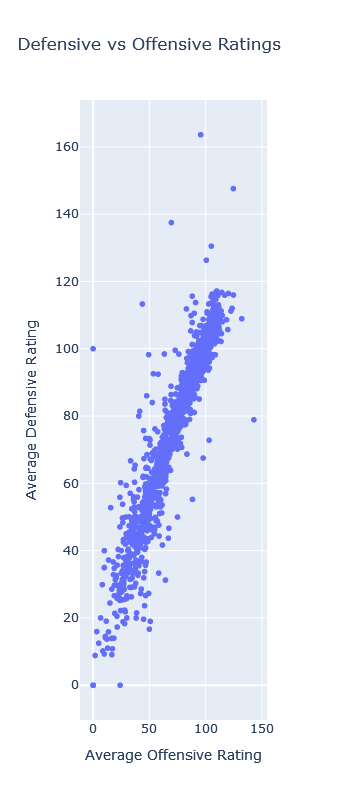

In [262]:
#first pretty picture
ratings_df = pd.DataFrame(columns=['Player', 'Average_Off_Rating', 'Average_Def_Rating'])

for player, df in player_box.items():
    avg_off_rating = df['offensiveRating'].mean()
    avg_def_rating = df['defensiveRating'].mean()
    player_df = pd.DataFrame({
        'Player': [player],
        'Average_Off_Rating': [avg_off_rating],
        'Average_Def_Rating': [avg_def_rating]
    })
    ratings_df = pd.concat([ratings_df, player_df], ignore_index=True)


fig = px.scatter(
    ratings_df,
    x='Average_Off_Rating',
    y='Average_Def_Rating',
    title='Defensive vs Offensive Ratings of Each Player',
    labels={'Average_Off_Rating': 'Average Offensive Rating', 'Average_Def_Rating': 'Average Defensive Rating'}
)

# Update traces to customize hover labels GPT
fig.update_traces(
    hovertemplate='<b>%{text}</b><br>Offensive Rating: %{x}<br>Defensive Rating: %{y}<extra></extra>',
    text=ratings_df['Player'],
    mode='markers'  
)

# Ulayout 
fig.update_layout(
    xaxis_title='Average Offensive Rating',
    yaxis_title='Average Defensive Rating',
    title='Defensive vs Offensive Ratings',
    hovermode='closest',
    width=800, 
    height = 800
)

# Show the plot
fig.show()

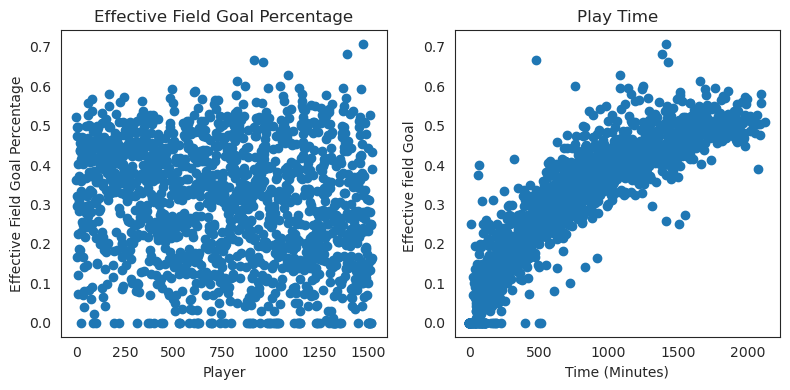

In [14]:
fig, ax = plt.subplots(1,2, figsize=(8, 4), dpi=100)

# Effective Field Goal Percentage
ax[0].scatter(box23_24_player.index, box23_24_player['effectiveFieldGoalPercentage'])
ax[0].set_title('Effective Field Goal Percentage')
ax[0].set_xlabel('Player')
ax[0].set_ylabel('Effective Field Goal Percentage')

# Play Time
ax[1].scatter( box23_24_player['minutes'],box23_24_player['effectiveFieldGoalPercentage'])
ax[1].set_title('Play Time vs Effective Field Goal Percentage')
ax[1].set_ylabel('Effective field Goal ')
ax[1].set_xlabel('Time (Minutes)')

plt.tight_layout()
plt.show()

# Cluster Shot selection

In [93]:
 cluster_shots[cluster_shots['cluster'] == cluster]

NameError: name 'cluster_shots' is not defined

In [ ]:
for prefix in season_prefixs:
    results_id = season_cluster_dict[prefix][['personId','cluster']]
    cluster_shots = results_id.merge(season_shot_dict[prefix], left_on='personId', right_on= 'PLAYER_ID',how = 'outer')
    cluster_shots.dropna(inplace = True)
    cluster_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] 
    from matplotlib.colors import Normalize
    fig, ax = plt.subplots(7, 2, figsize=(16, 32), dpi=100)
    ax = ax.flatten() 
    
    #set scale 
    global_min = np.inf
    global_max = -np.inf
    
    for cluster in cluster_index:
        shots = cluster_shots[cluster_shots['cluster'] == cluster]
        kde = sns.kdeplot(x=shots.LOC_X, y=shots.LOC_Y, fill=True)
        density = kde.collections[0].get_paths()[0].vertices
        global_min = min(global_min, np.min(density[:, 1]))
        global_max = max(global_max, np.max(density[:, 1]))
    
    plt.close()
    
    # Normalize colormap scale based on global density range
    norm = Normalize(vmin=global_min, vmax=global_max)
    
    for i, cluster in enumerate(cluster_index):
        shots = cluster_shots[cluster_shots['cluster'] == cluster]
        sp.shot_chart(shots.LOC_X, shots.LOC_Y, title=f"Cluster {cluster+1} Shot Selection", ax=ax[i],)# kind='kde', hue_norm =norm)
    
    plt.tight_layout()
    #plt.show()
    
    fig.savefig(f'{prefix} shot_charts.png', format='png')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize

# Assuming 'season_cluster_dict' and 'season_shot_dict' are already defined
for prefix in season_prefixs:
    results_id = season_cluster_dict[prefix][['personId', 'cluster']]
    cluster_shots = results_id.merge(season_shot_dict[prefix], left_on='personId', right_on='PLAYER_ID', how='outer')
    cluster_shots.dropna(inplace=True)
    cluster_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] 
    
    fig, ax = plt.subplots(7, 2, figsize=(16, 32), dpi=100)
    ax = ax.flatten()

    # Set global density range
    global_min = np.inf
    global_max = -np.inf
    
    kde_densities = []

    # First loop: compute the KDE and find the global min and max for the density
    for cluster in cluster_index:
        shots = cluster_shots[cluster_shots['cluster'] == cluster]

        if len(shots) > 1:  # Ensure enough points for KDE
            loc_data = np.vstack([shots.LOC_X, shots.LOC_Y])
            kde = gaussian_kde(loc_data)
            # Evaluate the KDE over a grid
            x_grid, y_grid = np.mgrid[-250:250:100j, -50:450:100j]
            positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
            density = kde(positions).reshape(x_grid.shape)

            if np.any(density):  # Ensure density is not all zeros
                kde_densities.append(density)
                # Find global min and max of density
                global_min = min(global_min, density.min())
                global_max = max(global_max, density.max())
            else:
                kde_densities.append(None)  # Append None if density is empty
        else:
            kde_densities.append(None)  # In case there are no valid shots for this cluster

    # Normalize colormap scale based on global density range
    norm = Normalize(vmin=global_min, vmax=global_max)

    # Second loop: plot the KDEs with normalized colormap
    for i, cluster in enumerate(cluster_index):
        shots = cluster_shots[cluster_shots['cluster'] == cluster]
    
        # Check if kde_densities[i] is valid (not None, non-empty, and contains non-zero values)
        if kde_densities[i] is not None and kde_densities[i].size > 0 and np.any(kde_densities[i] > 0):
            x_grid, y_grid = np.mgrid[-250:250:100j, -50:450:100j]
            sp.shot_chart(x_grid.ravel(), y_grid.ravel(), title=f"Cluster {cluster+1} Shot Selection", 
                          ax=ax[i], kind='kde', hue=kde_densities[i].ravel(), hue_norm=norm)
        else:
            ax[i].set_title(f"Cluster {cluster+1} Shot Selection (No Data)")

    plt.tight_layout()

    # Save the figure
    fig.savefig(f'{prefix}_shot_charts.png', format='png')


In [74]:
id_cols = big_box[['personId',  'teamName', 'firstName', 'familyName', 'playerSlug']].drop_duplicates(subset='personId')
lookup = season_cluster_dict['218'][['personId','cluster']].merge(id_cols, on = 'personId',how= 'inner')

cluster_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] 

group_names = {}
for c in cluster_index:
    group = lookup[lookup['cluster']== c]
    group_names[c] = group

In [75]:
group_names[2].sample(7)

personId  cluster   teamName firstName familyName       playerSlug
346  1627786.0        2  Grizzlies      Troy   Williams    troy-williams
452  1628970.0        2    Hornets     Miles    Bridges    miles-bridges
302  1626220.0        2       Jazz     Royce    O'Neale     royce-oneale
269  1626150.0        2  Grizzlies    Andrew   Harrison  andrew-harrison
197   203485.0        2      76ers   Lorenzo      Brown    lorenzo-brown
212   203518.0        2    Thunder      Alex    Abrines     alex-abrines
456  1628975.0        2  Grizzlies     Jevon     Carter     jevon-carter

# Cluster Thoughts   

### Cluster 1 
    reconizable players: Chris Paul 

### Cluster 2


### Cluster 3 
    reconizable players: James Harden, Kyrie Irving, Paul George, Stephen Curry, Kevin 	Durant,
    heavy hitters
### Cluster 4
    reconizable players: 

### Cluster 5


### Cluster 6


### Cluster 7


### Cluster 8


### Cluster 9


### Cluster 10
    low playing time 
    

### Cluster 11


### Cluster 12


### Cluster 13


### Cluster 14



In [210]:
results.groupby('cluster').mean(numeric_only=True).reset_index().drop('personId')

cluster      personId      minutes  offensiveRating  defensiveRating  netRating  assistPercentage  assistToTurnover  assistRatio  offensiveReboundPercentage  defensiveReboundPercentage  reboundPercentage  turnoverRatio  effectiveFieldGoalPercentage  trueShootingPercentage  usagePercentage        pace   pacePer40       PIE     speed  distance  reboundChancesOffensive  reboundChancesDefensive  reboundChancesTotal    touches  secondaryAssists  freeThrowAssists     passes   assists  contestedFieldGoalsMade  contestedFieldGoalsAttempted  contestedFieldGoalPercentage  uncontestedFieldGoalsMade  uncontestedFieldGoalsAttempted  uncontestedFieldGoalsPercentage  fieldGoalPercentage  defendedAtRimFieldGoalsMade  defendedAtRimFieldGoalsAttempted  defendedAtRimFieldGoalPercentage  fieldGoalsMade  fieldGoalsAttempted  fieldGoalsPercentage  threePointersMade  threePointersAttempted  threePointersPercentage  freeThrowsMade  freeThrowsAttempted  freeThrowsPercentage  reboundsOffensive  \
0         0  9.918953e+05  1303.356722       105.136035       107.676294  -2.540241          0.229806          1.894531    29.924240                    0.025360                    0.105783           0.065447       9.894895                      0.471506                0.495631         0.148537   96.143464   80.119516  0.082533  4.072412  1.651697                 1.438085                 4.019135             5.347095  43.082087          0.442387          0.390136  33.872146  3.865043                 1.101352                      2.371821                      0.366167                   1.776221                        4.022851                         0.385503             0.408999                     1.210835                          1.698768                          0.546575        2.901770             6.458342              0.409199           0.866142                2.378463                 0.263044        0.820711             1.072586              0.298898           0.596857   
1         1  1.413636e+06  1505.301381       110.483900       109.612497   0.870802          0.099785          0.854094    16.389365                    0.027747                    0.102268           0.065013       8.305456                      0.537156                0.558181         0.151910   97.485144   81.237573  0.071510  4.146244  1.905495                 1.787221                 4.550055             6.176819  33.758900          0.264947          0.158887  23.756240  1.883920                 1.155983                      2.294182                      0.402198                   2.416013                        5.466146                         0.408267             0.433903                     1.553860                          2.292134                          0.576889        3.613678             7.852343              0.434147           1.695358                4.382234                 0.351095        1.052142             1.339812              0.364350           0.725260   
2         2  1.162191e+06  2040.556002       115.501180       110.705991   4.795574          0.269856          2.647499    21.229976                    0.023398                    0.121194           0.073243       8.720755                      0.534592                0.581315         0.270701   98.030186   81.691872  0.137887  3.934402  2.429599                 2.133293                 6.672738             8.626887  71.423723          0.887104          0.581072  46.876364  6.159161                 3.417399                      6.850877                      0.472324                   4.849152                       10.422932                         0.454025             0.466288                     1.825466                          2.621702                          0.613596        8.370628            17.486719              0.466672           2.401980                6.337773                 0.347478        4.495653             5.404366              0.754523           0.808552   
3         3  1.512912e+06   803.764993      

In [211]:
results.columns

Index(['personId', 'cluster', 'minutes', 'offensiveRating', 'defensiveRating', 'netRating', 'assistPercentage', 'assistToTurnover', 'assistRatio', 'offensiveReboundPercentage', 'defensiveReboundPercentage', 'reboundPercentage', 'turnoverRatio', 'effectiveFieldGoalPercentage', 'trueShootingPercentage', 'usagePercentage', 'pace', 'pacePer40', 'PIE', 'speed', 'distance', 'reboundChancesOffensive', 'reboundChancesDefensive', 'reboundChancesTotal', 'touches', 'secondaryAssists', 'freeThrowAssists', 'passes', 'assists', 'contestedFieldGoalsMade', 'contestedFieldGoalsAttempted', 'contestedFieldGoalPercentage', 'uncontestedFieldGoalsMade', 'uncontestedFieldGoalsAttempted', 'uncontestedFieldGoalsPercentage', 'fieldGoalPercentage', 'defendedAtRimFieldGoalsMade', 'defendedAtRimFieldGoalsAttempted', 'defendedAtRimFieldGoalPercentage', 'fieldGoalsMade', 'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade', 'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade',
       '

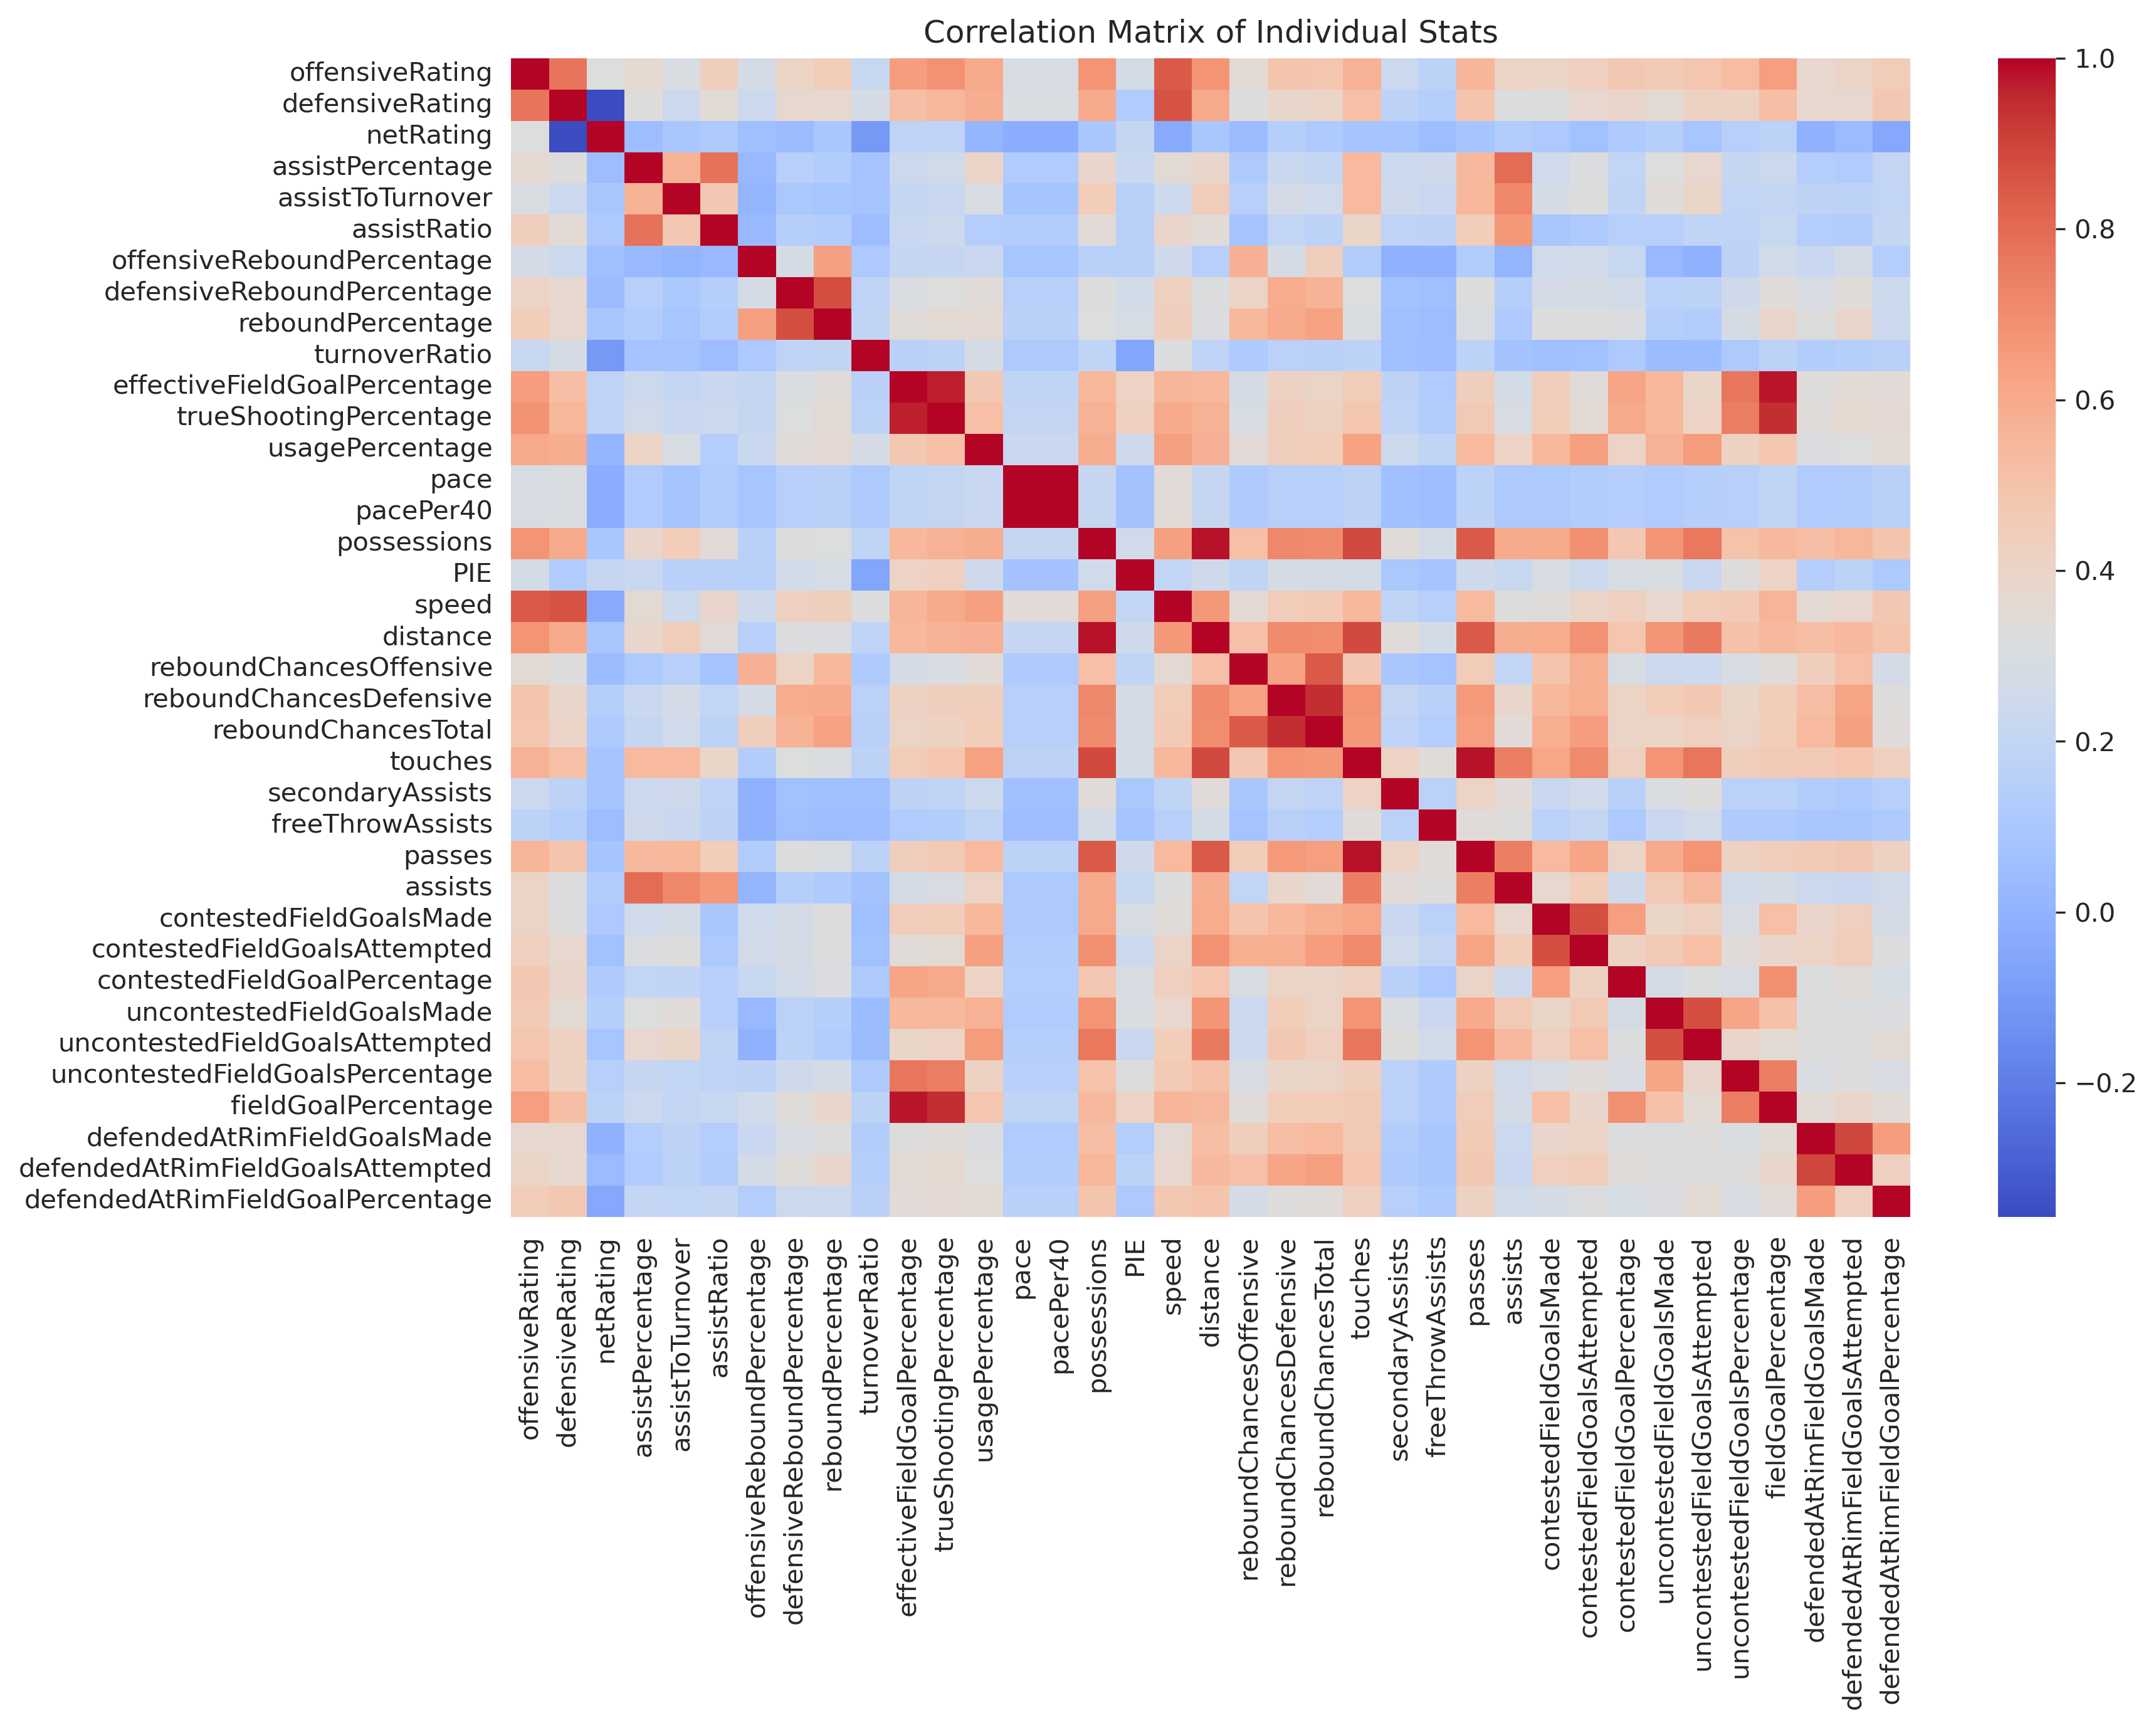

In [87]:
numeric_big_box = big_box.select_dtypes(include=np.number)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
numeric_big_box.drop(['gameId','teamId','personId'],axis=1, inplace=True)
numeric_big_box.drop(numeric_big_box.filter(like='estimated').columns, axis=1,inplace = True)

sns.heatmap(numeric_big_box.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Individual Stats')
plt.show()
fig.savefig('individual_correlation_matrix.png', format='png')

In [87]:
import torch
import intel_extension_for_pytorch as ipex
from torch import nn
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.base import BaseEstimator

# Move tensors to GPU if available
device = ('xpu')

# K-means implementation with PyTorch
def kmeans_pytorch(X, n_clusters, n_rand=1):
    X = X.to(device)  # Ensure the data is on the GPU
    best_labels = None
    best_silhouette = -100

    for trial in range(n_rand):
        random_state = np.random.randint(1, 1000)
        # Randomly initialize cluster centers
        centroids = X[torch.randint(0, X.shape[0], (n_clusters,))]

        for _ in range(100):  # Iterate until convergence
            distances = torch.cdist(X, centroids)  # Calculate distances from points to centroids
            labels = torch.argmin(distances, dim=1)  # Assign labels based on closest centroid
            new_centroids = torch.stack([X[labels == i].mean(dim=0) for i in range(n_clusters)])  # Recompute centroids
            
            # If a centroid has no points, reinitialize it
            for i in range(n_clusters):
                if (labels == i).sum() == 0:  # No points assigned to this centroid
                    new_centroids[i] = X[torch.randint(0, X.shape[0], (1,))]

            if torch.all(centroids == new_centroids):  # Check for convergence
                break
            centroids = new_centroids
        
        # Compute silhouette score only if more than one label
        if len(torch.unique(labels)) > 1:
            silhouette_avg = silhouette_score(X.cpu().numpy(), labels.cpu().numpy())
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_labels = labels
    
    return best_labels, best_silhouette


# Area under the silhouette curve using PyTorch
def silhouette_auc_torch(X, clusters_range):  # Calculate the area under the silhouette curve
    scores = []
    for n_clusters in clusters_range:
        labels, silhouette_avg = kmeans_pytorch(X, n_clusters, n_rand=1)
        scores.append(silhouette_avg)
    return np.trapz(scores, clusters_range)

# Forward Feature Selection
def forward_feature_selection(X, n_clusters_range):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    while remaining_features:
        best_score = -1
        best_feature = None
        
        for feature in remaining_features:
            # Select current feature
            current_features = selected_features + [feature]
            X_subset = X[:, current_features]

            # Compute silhouette score
            _, silhouette_avg = kmeans_pytorch(X_subset, n_clusters=n_clusters_range[-1], n_rand=1)

            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_feature = feature
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            #print(f"Selected feature: {best_feature}, Score: {best_score}")

    return selected_features


# Main script
season_prefixes = ['213','214','215','216','217','218','219','220','221','222','223']
games = list(set(map(str, big_box['gameId'])))
season_game_dict = {s: [float(g) for g in games if g.startswith(s)] for s in season_prefixes}

# Iterating through the seasons
for s in season_game_dict:
    games = season_game_dict[s]
    
    # Get season's data
    season_big_box = big_box[big_box['gameId'].isin(games)]
    season_team_game_stats = team_game_stats[team_game_stats['GAME_ID'].isin(games)]
    season_shot_chart = player_shotchart_data[player_shotchart_data['GAME_ID'].isin(games)]
    season_player_play_type = player_play_type[player_play_type['SEASON_ID'].astype(str).str[-2:] == str(s)[-2:]]

    # Pivot play type data
    season_player_play_type = season_player_play_type.pivot_table(index='PLAYER_ID', columns=['TYPE_GROUPING', 'PLAY_TYPE'], values='PERCENTILE').fillna(0)
    season_player_play_type.columns = ['_'.join(col).strip() for col in season_player_play_type.columns.values]
    
    # Prepare data for clustering
    X = cluster4000(season_big_box, season_shot_chart, season_player_play_type)

    # Scale and remove low variance columns
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    # Forward feature selection
    n_clusters_range = range(5, 10)
    selected_indices = forward_feature_selection(X_scaled, n_clusters_range)
    selected_feature_names = X.columns[selected_indices].tolist()

    print(f'Selected features for season {s}: {selected_feature_names}')


Selected features for season 213: ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Left_Corner_3', 'shot_attempts_Left_Corner_3', 'made_shots_Right_Corner_3', 'shot_attempts_Right_Corner_3', 'shot_attempts_Above_the_Break_3', 'made_shots_Above_the_Break_3', 'gameId', 'assistPercentage', 'assistToTurnover', 'passes', 'minutes', 'uncontestedFieldGoalsPercentage', 'uncontestedFieldGoalsAttempted', 'contestedFieldGoalPercentage', 'made_shots_In_The_Paint_(Non-RA)', 'PIE', 'reboundChancesOffensive', 'contestedFieldGoalsMade', 'contestedFieldGoalsAttempted', 'defendedAtRimFieldGoalsMade', 'touches', 'assists', 'made_shots_Restricted_Area', 'shot_attempts_In_The_Paint_(Non-RA)', 'defendedAtRimFieldGoalsAttempted', 'distance', 'secondaryAssists', 'trueShootingPercentage', 'defendedAtRimFieldGoalPercentage', 'assistRatio', 'usagePercentage', 'fieldGoalPercentage', 'offensiveRating', 'reboundChancesDefensive', 'reboundPercentage', 'reboundChancesTotal', 'speed', 'shot_attempts_Res

In [92]:
Selected_features_213 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Left_Corner_3', 'shot_attempts_Left_Corner_3', 'shot_attempts_Above_the_Break_3', 'made_shots_Right_Corner_3', 'made_shots_Above_the_Break_3', 'assists', 'shot_attempts_Right_Corner_3', 'assistToTurnover', 'gameId', 'distance', 'uncontestedFieldGoalsMade', 'uncontestedFieldGoalsAttempted', 'touches', 'defensiveReboundPercentage', 'freeThrowAssists', 'trueShootingPercentage', 'assistPercentage', 'effectiveFieldGoalPercentage', 'reboundChancesOffensive', 'reboundChancesTotal', 'shot_attempts_In_The_Paint_(Non-RA)', 'offensiveReboundPercentage', 'defendedAtRimFieldGoalsMade', 'shot_attempts_Restricted_Area', 'reboundChancesDefensive', 'contestedFieldGoalsAttempted', 'speed', 'shot_attempts_Mid-Range', 'fieldGoalPercentage', 'secondaryAssists', 'reboundPercentage', 'defendedAtRimFieldGoalsAttempted', 'usagePercentage', 'PIE', 'contestedFieldGoalsMade', 'minutes', 'turnoverRatio', 'pace', 'pacePer40', 'made_shots_Mid-Range', 'made_shots_In_The_Paint_(Non-RA)', 'defendedAtRimFieldGoalPercentage', 'made_shots_Restricted_Area', 'passes', 'assistRatio', 'offensiveRating', 'contestedFieldGoalPercentage', 'defensiveRating', 'uncontestedFieldGoalsPercentage', 'netRating']
Selected_features_214 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Right_Corner_3', 'shot_attempts_Left_Corner_3', 'shot_attempts_Right_Corner_3', 'made_shots_Left_Corner_3', 'shot_attempts_Above_the_Break_3', 'made_shots_Above_the_Break_3', 'made_shots_Mid-Range', 'shot_attempts_Mid-Range', 'uncontestedFieldGoalsAttempted', 'uncontestedFieldGoalsMade', 'assistToTurnover', 'assists', 'minutes', 'distance', 'contestedFieldGoalsMade', 'uncontestedFieldGoalsPercentage', 'freeThrowAssists', 'effectiveFieldGoalPercentage', 'defendedAtRimFieldGoalsMade', 'assistPercentage', 'offensiveReboundPercentage', 'reboundChancesTotal', 'contestedFieldGoalsAttempted', 'assistRatio', 'gameId', 'reboundChancesOffensive', 'contestedFieldGoalPercentage', 'trueShootingPercentage', 'made_shots_Restricted_Area', 'touches', 'offensiveRating', 'passes', 'shot_attempts_Restricted_Area', 'secondaryAssists', 'made_shots_In_The_Paint_(Non-RA)', 'fieldGoalPercentage', 'turnoverRatio', 'defensiveReboundPercentage', 'defendedAtRimFieldGoalsAttempted', 'netRating', 'pace', 'defendedAtRimFieldGoalPercentage', 'usagePercentage', 'defensiveRating', 'PIE', 'reboundChancesDefensive', 'shot_attempts_In_The_Paint_(Non-RA)', 'pacePer40', 'reboundPercentage', 'speed']
Selected_features_215 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Right_Corner_3', 'shot_attempts_Right_Corner_3', 'shot_attempts_Left_Corner_3', 'made_shots_Left_Corner_3', 'shot_attempts_Above_the_Break_3', 'made_shots_Above_the_Break_3', 'shot_attempts_Mid-Range', 'made_shots_Mid-Range', 'made_shots_In_The_Paint_(Non-RA)', 'gameId', 'offensiveRating', 'assistToTurnover', 'trueShootingPercentage', 'contestedFieldGoalsMade', 'fieldGoalPercentage', 'uncontestedFieldGoalsPercentage', 'defendedAtRimFieldGoalsAttempted', 'offensiveReboundPercentage', 'reboundChancesDefensive', 'defendedAtRimFieldGoalPercentage', 'reboundChancesTotal', 'passes', 'assists', 'distance', 'effectiveFieldGoalPercentage', 'made_shots_Restricted_Area', 'turnoverRatio', 'usagePercentage', 'freeThrowAssists', 'reboundPercentage', 'pacePer40', 'secondaryAssists', 'touches', 'uncontestedFieldGoalsAttempted', 'uncontestedFieldGoalsMade', 'contestedFieldGoalsAttempted', 'contestedFieldGoalPercentage', 'defensiveRating', 'shot_attempts_Restricted_Area', 'assistPercentage', 'shot_attempts_In_The_Paint_(Non-RA)', 'assistRatio', 'minutes', 'reboundChancesOffensive', 'PIE', 'defensiveReboundPercentage', 'pace', 'defendedAtRimFieldGoalsMade', 'netRating', 'speed']
Selected_features_216 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Left_Corner_3', 'made_shots_Right_Corner_3', 'shot_attempts_Left_Corner_3', 'shot_attempts_Right_Corner_3', 'shot_attempts_Above_the_Break_3', 'made_shots_Above_the_Break_3', 'made_shots_Mid-Range', 'uncontestedFieldGoalsAttempted', 'uncontestedFieldGoalsMade', 'shot_attempts_In_The_Paint_(Non-RA)', 'contestedFieldGoalsMade', 'made_shots_Restricted_Area', 'touches', 'passes', 'shot_attempts_Restricted_Area', 'made_shots_In_The_Paint_(Non-RA)', 'minutes', 'defendedAtRimFieldGoalsAttempted', 'gameId', 'reboundChancesOffensive', 'secondaryAssists', 'reboundChancesTotal', 'contestedFieldGoalsAttempted', 'fieldGoalPercentage', 'contestedFieldGoalPercentage', 'reboundChancesDefensive', 'distance', 'defensiveRating', 'reboundPercentage', 'pacePer40', 'usagePercentage', 'effectiveFieldGoalPercentage', 'trueShootingPercentage', 'defendedAtRimFieldGoalsMade', 'assistPercentage', 'freeThrowAssists', 'PIE', 'pace', 'offensiveReboundPercentage', 'speed', 'shot_attempts_Mid-Range', 'defendedAtRimFieldGoalPercentage', 'assists', 'defensiveReboundPercentage', 'assistToTurnover', 'offensiveRating', 'assistRatio', 'uncontestedFieldGoalsPercentage', 'netRating', 'turnoverRatio']
Selected_features_217 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'shot_attempts_Right_Corner_3', 'made_shots_Right_Corner_3', 'shot_attempts_Left_Corner_3', 'made_shots_Above_the_Break_3', 'shot_attempts_Above_the_Break_3', 'made_shots_Left_Corner_3', 'made_shots_In_The_Paint_(Non-RA)', 'made_shots_Mid-Range', 'reboundChancesOffensive', 'shot_attempts_In_The_Paint_(Non-RA)', 'passes', 'shot_attempts_Mid-Range', 'reboundChancesTotal', 'made_shots_Restricted_Area', 'trueShootingPercentage', 'effectiveFieldGoalPercentage', 'defendedAtRimFieldGoalsMade', 'contestedFieldGoalsMade', 'contestedFieldGoalPercentage', 'secondaryAssists', 'minutes', 'reboundChancesDefensive', 'defendedAtRimFieldGoalsAttempted', 'offensiveRating', 'speed', 'contestedFieldGoalsAttempted', 'uncontestedFieldGoalsMade', 'assists', 'assistToTurnover', 'uncontestedFieldGoalsPercentage', 'reboundPercentage', 'shot_attempts_Restricted_Area', 'pacePer40', 'touches', 'distance', 'pace', 'defensiveRating', 'PIE', 'defendedAtRimFieldGoalPercentage', 'defensiveReboundPercentage', 'fieldGoalPercentage', 'uncontestedFieldGoalsAttempted', 'freeThrowAssists', 'usagePercentage', 'netRating', 'offensiveReboundPercentage', 'assistRatio', 'turnoverRatio', 'assistPercentage', 'gameId']
Selected_features_218 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Right_Corner_3', 'shot_attempts_Right_Corner_3', 'shot_attempts_Left_Corner_3', 'made_shots_Left_Corner_3', 'made_shots_Above_the_Break_3', 'shot_attempts_Mid-Range', 'made_shots_Mid-Range', 'shot_attempts_Above_the_Break_3', 'assists', 'made_shots_Restricted_Area', 'uncontestedFieldGoalsMade', 'minutes', 'assistRatio', 'defendedAtRimFieldGoalsMade', 'shot_attempts_Restricted_Area', 'reboundChancesTotal', 'defendedAtRimFieldGoalsAttempted', 'uncontestedFieldGoalsAttempted', 'passes', 'effectiveFieldGoalPercentage', 'offensiveReboundPercentage', 'usagePercentage', 'offensiveRating', 'reboundChancesOffensive', 'PIE', 'defensiveReboundPercentage', 'reboundPercentage', 'gameId', 'reboundChancesDefensive', 'contestedFieldGoalsAttempted', 'distance', 'assistToTurnover', 'freeThrowAssists', 'made_shots_In_The_Paint_(Non-RA)', 'shot_attempts_In_The_Paint_(Non-RA)', 'touches', 'secondaryAssists', 'pacePer40', 'speed', 'contestedFieldGoalPercentage', 'defensiveRating', 'netRating', 'turnoverRatio', 'assistPercentage', 'contestedFieldGoalsMade', 'fieldGoalPercentage', 'uncontestedFieldGoalsPercentage', 'trueShootingPercentage', 'defendedAtRimFieldGoalPercentage', 'pace']
Selected_features_219 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Left_Corner_3', 'shot_attempts_Left_Corner_3', 'shot_attempts_Right_Corner_3', 'shot_attempts_Above_the_Break_3', 'made_shots_Right_Corner_3', 'shot_attempts_Mid-Range', 'made_shots_In_The_Paint_(Non-RA)', 'made_shots_Above_the_Break_3', 'made_shots_Mid-Range', 'freeThrowAssists', 'defendedAtRimFieldGoalsMade', 'reboundChancesDefensive', 'assistToTurnover', 'shot_attempts_In_The_Paint_(Non-RA)', 'touches', 'uncontestedFieldGoalsAttempted', 'passes', 'contestedFieldGoalsAttempted', 'contestedFieldGoalPercentage', 'distance', 'reboundChancesTotal', 'contestedFieldGoalsMade', 'defendedAtRimFieldGoalPercentage', 'minutes', 'offensiveRating', 'uncontestedFieldGoalsPercentage', 'reboundPercentage', 'defendedAtRimFieldGoalsAttempted', 'assists', 'usagePercentage', 'reboundChancesOffensive', 'gameId', 'made_shots_Restricted_Area', 'effectiveFieldGoalPercentage', 'shot_attempts_Restricted_Area', 'defensiveReboundPercentage', 'trueShootingPercentage', 'fieldGoalPercentage', 'pace', 'secondaryAssists', 'assistRatio', 'offensiveReboundPercentage', 'uncontestedFieldGoalsMade', 'assistPercentage', 'speed', 'pacePer40', 'PIE', 'defensiveRating', 'netRating', 'turnoverRatio']
Selected_features_220 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'defensiveRating', 'pace', 'pacePer40', 'speed', 'offensiveRating', 'trueShootingPercentage', 'effectiveFieldGoalPercentage', 'distance', 'uncontestedFieldGoalsPercentage', 'made_shots_Mid-Range', 'shot_attempts_Mid-Range', 'gameId', 'contestedFieldGoalPercentage', 'uncontestedFieldGoalsMade', 'PIE', 'freeThrowAssists', 'reboundChancesDefensive', 'made_shots_Left_Corner_3', 'contestedFieldGoalsMade', 'shot_attempts_Restricted_Area', 'made_shots_Right_Corner_3', 'defendedAtRimFieldGoalPercentage', 'uncontestedFieldGoalsAttempted', 'defendedAtRimFieldGoalsAttempted', 'defendedAtRimFieldGoalsMade', 'assistToTurnover', 'passes', 'touches', 'shot_attempts_Left_Corner_3', 'minutes', 'reboundChancesTotal', 'assists', 'reboundPercentage', 'shot_attempts_In_The_Paint_(Non-RA)', 'shot_attempts_Right_Corner_3', 'made_shots_In_The_Paint_(Non-RA)', 'contestedFieldGoalsAttempted', 'made_shots_Restricted_Area', 'usagePercentage', 'secondaryAssists', 'fieldGoalPercentage', 'shot_attempts_Above_the_Break_3', 'reboundChancesOffensive', 'defensiveReboundPercentage', 'assistPercentage', 'netRating', 'made_shots_Above_the_Break_3', 'assistRatio', 'turnoverRatio', 'offensiveReboundPercentage']
Selected_features_221 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Mid-Range', 'shot_attempts_Mid-Range', 'shot_attempts_Above_the_Break_3', 'made_shots_Above_the_Break_3', 'shot_attempts_Left_Corner_3', 'shot_attempts_Right_Corner_3', 'made_shots_Right_Corner_3', 'made_shots_Left_Corner_3', 'made_shots_Restricted_Area', 'shot_attempts_In_The_Paint_(Non-RA)', 'shot_attempts_Restricted_Area', 'made_shots_In_The_Paint_(Non-RA)', 'contestedFieldGoalsMade', 'assistToTurnover', 'contestedFieldGoalsAttempted', 'usagePercentage', 'minutes', 'assists', 'defendedAtRimFieldGoalsMade', 'reboundChancesTotal', 'effectiveFieldGoalPercentage', 'fieldGoalPercentage', 'defendedAtRimFieldGoalsAttempted', 'reboundChancesOffensive', 'defendedAtRimFieldGoalPercentage', 'uncontestedFieldGoalsPercentage', 'reboundPercentage', 'assistPercentage', 'passes', 'contestedFieldGoalPercentage', 'assistRatio', 'offensiveRating', 'distance', 'defensiveReboundPercentage', 'freeThrowAssists', 'touches', 'uncontestedFieldGoalsAttempted', 'turnoverRatio', 'trueShootingPercentage', 'defensiveRating', 'PIE', 'uncontestedFieldGoalsMade', 'offensiveReboundPercentage', 'secondaryAssists', 'pace', 'speed', 'reboundChancesDefensive', 'pacePer40', 'netRating', 'gameId']
Selected_features_222=  ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'made_shots_Left_Corner_3', 'shot_attempts_Left_Corner_3', 'shot_attempts_Right_Corner_3', 'made_shots_Right_Corner_3', 'made_shots_Above_the_Break_3', 'shot_attempts_Above_the_Break_3', 'shot_attempts_Mid-Range', 'made_shots_Mid-Range', 'distance', 'assistToTurnover', 'secondaryAssists', 'minutes', 'gameId', 'passes', 'uncontestedFieldGoalsMade', 'pacePer40', 'defendedAtRimFieldGoalsMade', 'defendedAtRimFieldGoalsAttempted', 'contestedFieldGoalsMade', 'uncontestedFieldGoalsPercentage', 'defensiveRating', 'reboundChancesTotal', 'shot_attempts_In_The_Paint_(Non-RA)', 'reboundChancesDefensive', 'made_shots_In_The_Paint_(Non-RA)', 'shot_attempts_Restricted_Area', 'freeThrowAssists', 'made_shots_Restricted_Area', 'pace', 'contestedFieldGoalPercentage', 'uncontestedFieldGoalsAttempted', 'assistRatio', 'reboundChancesOffensive', 'turnoverRatio', 'assists', 'contestedFieldGoalsAttempted', 'assistPercentage', 'reboundPercentage', 'offensiveRating', 'effectiveFieldGoalPercentage', 'touches', 'PIE', 'defendedAtRimFieldGoalPercentage', 'fieldGoalPercentage', 'usagePercentage', 'offensiveReboundPercentage', 'netRating', 'defensiveReboundPercentage', 'trueShootingPercentage', 'speed']
Selected_features_223 = ['made_shots_Backcourt', 'shot_attempts_Backcourt', 'shot_attempts_Mid-Range', 'made_shots_Mid-Range', 'shot_attempts_Above_the_Break_3', 'made_shots_Above_the_Break_3', 'made_shots_Left_Corner_3', 'made_shots_Right_Corner_3', 'uncontestedFieldGoalsMade', 'contestedFieldGoalsMade', 'uncontestedFieldGoalsAttempted', 'shot_attempts_Right_Corner_3', 'touches', 'passes', 'shot_attempts_Left_Corner_3', 'shot_attempts_Restricted_Area', 'minutes', 'contestedFieldGoalsAttempted', 'defendedAtRimFieldGoalsMade', 'defendedAtRimFieldGoalPercentage', 'shot_attempts_In_The_Paint_(Non-RA)', 'reboundChancesOffensive', 'gameId', 'assistToTurnover', 'fieldGoalPercentage', 'reboundChancesDefensive', 'turnoverRatio', 'defendedAtRimFieldGoalsAttempted', 'assists', 'made_shots_Restricted_Area', 'PIE', 'contestedFieldGoalPercentage', 'assistPercentage', 'distance', 'freeThrowAssists', 'trueShootingPercentage', 'speed', 'uncontestedFieldGoalsPercentage', 'made_shots_In_The_Paint_(Non-RA)', 'effectiveFieldGoalPercentage', 'assistRatio', 'secondaryAssists', 'defensiveReboundPercentage', 'usagePercentage', 'pacePer40', 'defensiveRating', 'reboundChancesTotal', 'offensiveRating', 'netRating', 'pace', 'reboundPercentage', 'offensiveReboundPercentage']


all_selected_features = set(Selected_features_223) | \
                        set(Selected_features_222) | \
                        set(Selected_features_221) | \
                        set(Selected_features_220) | \
                        set(Selected_features_219) | \
                        set(Selected_features_218) | \
                        set(Selected_features_217) | \
                        set(Selected_features_216) | \
                        set(Selected_features_215) | \
                        set(Selected_features_214) | \
                        set(Selected_features_213)

# Convert back to a list if needed
all_selected_features = list(set(all_selected_features))

In [93]:
len(all_selected_features)

52